 # Capstone Project 2 - In-Depth Analysis
## Name: Brock Nosbisch

### Summary:
This is a continuation from the "Capstone Project 2 - Data Wrangling", "Capstone Project 2 - Data Story", and "Capstone Project 2 - EDA" notebooks. The data from the EDA notebook was written to the eda_out.csv file which is read into this notebook. 
<br><br>
The problem I am trying to solve is to predict if a customer will turn off in XX number of days. The end goal is to come up with the best algorithm that produces the best Score (probability of turning off in XX number of days).  For the in-depth analysis, I am using the date of 3/1/2019 as the beginning date for the stops and evaluating a 21 day outlook.
<br><br>
I created a custom scorer so the amount of savings is provided.  For simplicity, I made the savings for scheduling a turn-off as 100 dollars and the cost of making a non-productive call as -10 dollars.  This will account for cases of saving money for scheduling a turn-off (or a customer staying on) and also account for a CSR or salesreps' time they spent calling customers that were never going to turn off.
<br><br>
The original data brought in is for a handful of random cities.  This was done to reduce the number of records brought into the original Data Wrangling notebook.  From the Active SAs as of 3/1/2019, I upsampled stops to 20,000 and downsampled the Active SAs (non-stops) to 40,000.  This was done to reduce training time.  If I was doing this for the real thing and it was going to inform decisions then I would take the time to train the whole sample and use a server to make the training run in a reasonable amount of time.  For the purpose of this capstone, I am using a smaller dataset so that it completes.
<br><br>
The Random Forest algorithm was the best performing by far.  The other algorithms run were outputting negative savings.  Do remember that the Savings values were picked at random by myself so the actual values a company chooses will be different.

### Results for each model tested:
| Algorithm                                                        | Savings        |
|------------------------------------------------------------------|----------------|
| Logistic Regression                                              |    -53,460.00  |
| Logistic Regression (Balanced Class Weight)                      |   -292,720.00  |
| k-NN (Best Neighbors, Uniform Weight)                            |    -26,260.00  |
| Random Forest                                                    |     24,560.00  |
| Random Forest (Max Features = 1 )                                |     18,560.00  |
| Random Forest (Max Features = 2 )                                |     20,280.00  |
| Random Forest (Max Features = 3 )                                |     22,770.00  |
| Random Forest (Max Features = 4 )                                |     24,190.00  |
| Random Forest (Max Features = 5 )                                |     24,560.00  |
| Random Forest (Balanced Weight Class, Max Features = 5)          |     23,600.00  |


### Results for Random Forest Split Up by Customer Class
<br>
The Customer Class was chosen to split up the data since Residential customers account for over 90% of customers but have < 1% stopped in the 21 day timeframe.  Landlord and Builders/Developers had 14% and 9% stop in the 21 day timeframe. <br>
Even though I thought splitting up by Customer Class would give better results, the overall totals were less than what I got with running Random Forest on the entire dataset.

| Algorithm                                                        | Savings        |
|------------------------------------------------------------------|----------------|
| Residential                                                      |     17,230.00  |
| Landlord, Building/Developer                                     |      1,240.00  |
| All Others                                                       |        140.00  |


<br><br>
### Random Forest Analysis of Individual Probabilities
Since the Random Forest algorithm was the best performing, I chose the "Random Forest (Balanced Weight Class, Max Features = 5)" algorithm to dig into the details and see the individual probabilities.  The Actual Stop % is good at the high predicted probabilities but there are fewer customers at the higher predicted probabilities.
<br><br>
You can see that if the company wanted to keep the accuracy of calling people who will actually stop over 30%, the company can choose to only call those people with more than a 80% chance of stopping.  The overall stats for the 80%+ chance of stopping predictions is a total of 248 predicted stops and 89 actual stops.  The overall actuals stop % would be around 36%.
<br><br>
This is the breakdown of Predicted Stop Count, Actual Stop Count, and Predicted Stop % by Predicted Probability:

| Predicted Probability | Predicted Stop Count | Actual Stop Count | Predicted Stop % |
|-----------------------|----------------------|-------------------|------------------|
| 0%                    | 0                    | 302               | 0%               |
| 10%                   | 0                    | 258               | 0%               |
| 20%                   | 0                    | 155               | 0%               |
| 30%                   | 0                    | 126               | 0%               |
| 40%                   | 0                    | 130               | 0%               |
| 50%                   | 409                  | 117               | 28.6%            |
| 60%                   | 664                  | 131               | 19.7%            |
| 70%                   | 455                  | 95                | 20.9%            |
| 80%                   | 175                  | 61                | 34.9%            |
| 90%                   | 59                   | 22                | 37.3%            |
| 100%                  | 14                   | 6                 | 42.9%            |


# Load Data

In [716]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)
from datetime import datetime, date

from scipy import stats
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import roc_curve, roc_auc_score, auc, confusion_matrix, classification_report, accuracy_score, SCORERS
from sklearn.metrics.scorer import make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import resample


# Functions #

def add_value_labels(ax, spacing=5):

    for rect in ax.patches:
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        space = spacing
        va = 'bottom'

        if y_value < 0:
            space *= -1
            # Vertical alignment
            va = 'top'

        label = "{:}".format(y_value)  # Use :.1f if wanting decimals.

        # Create annotation
        ax.annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va=va) 
        
def pearsonr_ci(x,y,alpha=0.05):

    r, p = stats.pearsonr(x,y)
    r_z = np.arctanh(r)
    se = 1/np.sqrt(x.size-3)
    z = stats.norm.ppf(1-alpha/2)
    low_z, high_z = r_z-z*se, r_z+z*se
    low, high = np.tanh((low_z, high_z))
    return r, p, low, high

# Bootstrap Replicates
def bootstrap_replicate_1d(data, func):
    return func(np.random.choice(data, size=len(data)))

# Test SVM
# Pass X_train, y_train, X_test, y_test, Maximum Iterations you want, C values in a list 
def svm_test(X_train, y_train, X_test, y_test, maxiter=1000, crange=[0.01,0.1,1,10,100]):
    # X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=10)
    model = svm.LinearSVC(C=1, random_state=50)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    #tune parameter C
    # crange = [0.01,0.1,1,10,100,1000]
    for num in crange:
        model = svm.LinearSVC(C=num, max_iter = maxiter)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        print ('C=' + str(num) + ',score={}'.format(accuracy_score(y_test,y_pred)))
        print(confusion_matrix(y_test, y_pred))
        
def print_stats(y_test, y_pred):
        
    savings_for_rescheduling = 100
    cost_of_nonproductive_call = -10
    missed_chance = 0 # No cost for missing a Stop but would have been better to catch.
    
    print('Confusion Matrix:')
    print(confusion_matrix(y_test, y_pred))
    print()
    print()
    tp, fn, fp, tn = confusion_matrix(y_test, y_pred).ravel()
    # total_profit = (tp * avg_loan_amount * avg_interest_rate * avg_loan_years) + (fp * avg_loan_amount * avg_interest_rate * avg_loan_years * -1) + (fn * avg_loan_amount * -1)
    total_savings = (tp*0) + (fp*missed_chance) + (fn*cost_of_nonproductive_call) + (tn*savings_for_rescheduling)
    
    print('Total Savings {}'.format(total_savings))
    print()
    print()
    print('Classification Report:')
    print(classification_report(y_test, y_pred))
    print()
    print('Accuracy Score: {}'.format(accuracy_score(y_test, y_pred)))
    
def print_cv_scores(clf, X_test, y_test, scoring_type, n_CV=5, jobs=-1):
    cv_scores = cross_val_score(clf, X_test, y_test, cv=n_CV, scoring=scoring_type, n_jobs=jobs)
    print('CV Scores:'.format(cv_scores) )
    print(cv_scores)
    print()
    print('Accuracy: %0.2f (+/- %0.2f)' % (cv_scores.mean(), cv_scores.std() * 2))
    print()
    cv_score_avg = np.mean(cv_scores)
    print('Total Savings: ' + str(cv_score_avg*n_CV))
    print()

file_name = 'eda_active_out.csv' # Service Agreement Level

df2=pd.DataFrame()

# Read in the file with new column names.
df2 = pd.read_csv(file_name, header=0)

# Change Data Types #
df2 = df2.astype({'ACCOUNT_ID':'str', 
                'PERSON_ID':'str', 
                'SA_STATUS_FLAG':'str', 
                'PREMISE_ID':'str',
                'POSTAL':'str',
                'SA_START_YEAR':'str',
                'SA_START_YEAR_MONTH':'str',
                'SA_END_YEAR':'str',
                'SA_END_YEAR_MONTH':'str',
                'SA_START_DATE':'datetime64[ns]',
                'SA_END_DATE':'datetime64[ns]',
                'MOST_RECENT_PAYMENT_DATE':'datetime64[ns]',
                'PERSON_MAX_SA_START_DATE':'datetime64[ns]',
                'PERSON_MIN_SA_START_DATE':'datetime64[ns]',   
                'PERSON_MAX_SA_END_DATE':'datetime64[ns]',
                'PERSON_MIN_SA_END_DATE':'datetime64[ns]',
                'PREMISE_MAX_SA_START_DATE':'datetime64[ns]',
                'PREMISE_MIN_SA_START_DATE':'datetime64[ns]',
                'PREMISE_MAX_SA_END_DATE':'datetime64[ns]',
                'PREMISE_MIN_SA_END_DATE':'datetime64[ns]',
                'PREMISE_PRIOR_STOP_DATE':'datetime64[ns]',
                'PERSON_PRIOR_STOP_DATE':'datetime64[ns]',
                'PLEDGE_DATE_2015':'datetime64[ns]',
                'PLEDGE_DATE_2016':'datetime64[ns]',
                'PLEDGE_DATE_2017':'datetime64[ns]',
                'PLEDGE_DATE_2018':'datetime64[ns]'
               })

# Removing columns that may leak data.
del df2['SA_END_DATE']
del df2['SA_END_YEAR']
del df2['SA_END_YEAR_MONTH']
del df2['SA_STATUS_FLAG']
del df2['SA_END_DEGREE_DAY']
del df2['SA_END_AVG_TEMP']
del df2['STOP_2019']
del df2['STOP_7_DAYS_FROM_20190301']
del df2['STOP_14_DAYS_FROM_20190301']

df2['CUSTOMER_CLASS_CODE_NUM'] = 0
df2.loc[((df2['CUSTOMER_CLASS_CODE'] == 'RES')), 'CUSTOMER_CLASS_CODE_NUM'] = 1
df2.loc[((df2['CUSTOMER_CLASS_CODE'] == 'COM')), 'CUSTOMER_CLASS_CODE_NUM'] = 2
df2.loc[((df2['CUSTOMER_CLASS_CODE'] == 'LOW')), 'CUSTOMER_CLASS_CODE_NUM'] = 3
df2.loc[((df2['CUSTOMER_CLASS_CODE'] == 'LL')), 'CUSTOMER_CLASS_CODE_NUM'] = 4
df2.loc[((df2['CUSTOMER_CLASS_CODE'] == 'BLDV')), 'CUSTOMER_CLASS_CODE_NUM'] = 5
df2.loc[((df2['CUSTOMER_CLASS_CODE'] == 'FCAP')), 'CUSTOMER_CLASS_CODE_NUM'] = 6
df2.loc[((df2['CUSTOMER_CLASS_CODE'] == 'IND')), 'CUSTOMER_CLASS_CODE_NUM'] = 7
df2.loc[((df2['CUSTOMER_CLASS_CODE'] == 'SGOV')), 'CUSTOMER_CLASS_CODE_NUM'] = 8
df2.loc[((df2['CUSTOMER_CLASS_CODE'] == 'TRNS')), 'CUSTOMER_CLASS_CODE_NUM'] = 9
df2.loc[((df2['CUSTOMER_CLASS_CODE'] == 'LV')), 'CUSTOMER_CLASS_CODE_NUM'] = 10
df2.loc[((df2['CUSTOMER_CLASS_CODE'] == 'IN')), 'CUSTOMER_CLASS_CODE_NUM'] = 11

df2['CITY_NUM'] = 0
df2.loc[((df2['CITY'] == 'BALLWIN')), 'CITY_NUM'] = 1
df2.loc[((df2['CITY'] == 'SAINT JOSEPH')), 'CITY_NUM'] = 2
df2.loc[((df2['CITY'] == 'INDEPENDENCE')), 'CITY_NUM'] = 3
df2.loc[((df2['CITY'] == 'O FALLON')), 'CITY_NUM'] = 4
df2.loc[((df2['CITY'] == 'SAINT CHARLES')), 'CITY_NUM'] = 5
df2.loc[((df2['CITY'] == 'LEES SUMMIT')), 'CITY_NUM'] = 6
df2.loc[((df2['CITY'] == 'CHESTERFIELD')), 'CITY_NUM'] = 7
df2.loc[((df2['CITY'] == 'SAINT PETERS')), 'CITY_NUM'] = 8
df2.loc[((df2['CITY'] == 'CAMERON')), 'CITY_NUM'] = 9
df2.loc[((df2['CITY'] == 'IMPERIAL')), 'CITY_NUM'] = 10
df2.loc[((df2['CITY'] == 'RAYTOWN')), 'CITY_NUM'] = 11
df2.loc[((df2['CITY'] == 'AURORA')), 'CITY_NUM'] = 12
df2.loc[((df2['CITY'] == 'MONETT')), 'CITY_NUM'] = 13
df2.loc[((df2['CITY'] == 'JOPLIN')), 'CITY_NUM'] = 14
df2.loc[((df2['CITY'] == 'BLUE SPRINGS')), 'CITY_NUM'] = 15
df2.loc[((df2['CITY'] == 'VALLEY PARK')), 'CITY_NUM'] = 16
df2.loc[((df2['CITY'] == 'PARKVILLE')), 'CITY_NUM'] = 17
df2.loc[((df2['CITY'] == 'ELLISVILLE')), 'CITY_NUM'] = 18
df2.loc[((df2['CITY'] == 'EUREKA')), 'CITY_NUM'] = 19
df2.loc[((df2['CITY'] == 'WEBB CITY')), 'CITY_NUM'] = 20
df2.loc[((df2['CITY'] == 'GROVER')), 'CITY_NUM'] = 21

X_r3['USAGE_PAST_18_BUCKET'].isnull()

df2.loc[((df2['USAGE_PAST_18_BUCKET'].isnull() == True)), 'USAGE_PAST_18_BUCKET'] = -1

df2.set_index('SA_ID', inplace=True)

## Train / Test / Split

In [717]:
# Used for train_test_split.
X = df2[['USAGE_PAST_18_BUCKET','CITY_NUM','CUSTOMER_CLASS_CODE_NUM','DNP_STARTED_FLAG_NUMBER','DNP_STOPPED_FLAG_NUMBER','INTERNAL_CREDIT_RATING','PERSON_RCVD_18_MTHS_PLEDGE_NUM','PAYMENTS_IN_LAST_18_MONTHS','BILLS_IN_LAST_18_MONTHS','ARREARS_PAYOFF_AMOUNT','TOTAL_PAYOFF_AMOUNT','LATE_PAYMENT_COUNT','SEASONAL_PRIOR_1_YR_FLAG_NUM','SEASONAL_PRIOR_2_YR_FLAG_NUM','SEASONAL_PRIOR_3_YR_FLAG_NUM','SA_START_AVG_TEMP','START_2013','START_2014','START_2015','START_2016','START_2017','START_2018','START_2019','PLEDGE_DATE_2017_NUM','PLEDGE_DATE_2018_NUM','PREMISE_DAYS_INACTIVE_BEFORE','PERSON_DAYS_INACTIVE_BEFORE','PREMISE_DAYS_ACTIVE_BEFORE','PERSON_DAYS_ACTIVE_BEFORE','ACTIVE_DIFF_FROM_20190301']]
y = df2['STOP_21_DAYS_FROM_20190301']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=50)

# Split the Training and Test Sets for upsampling.
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y, test_size=.4, random_state=50) 

X_train_2['STOP_21_DAYS_FROM_20190301'] = y_train_2

# Continuous Variables w/ Stop Flags
cont_vars = ['INTERNAL_CREDIT_RATING','PAYMENTS_IN_LAST_18_MONTHS','BILLS_IN_LAST_18_MONTHS','PAY_SEGS_IN_LAST_18_MONTHS','BILL_SEGS_IN_LAST_18_MONTHS','ARREARS_CURRENT_AMOUNT','ARREARS_PAYOFF_AMOUNT','TOTAL_CURRENT_AMOUNT','TOTAL_PAYOFF_AMOUNT','LATE_PAYMENT_COUNT','SA_START_AVG_TEMP','USAGE_IN_LAST_18_MONTHS','PREMISE_DAYS_INACTIVE_BEFORE','PERSON_DAYS_INACTIVE_BEFORE','PREMISE_DAYS_ACTIVE_BEFORE','PERSON_DAYS_ACTIVE_BEFORE','ACTIVE_DIFF_FROM_20190301','STOP_21_DAYS_FROM_20190301']

print()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


### Resampling to Upsample
There are 3 resamples done.  The 20k Stops and 40k Active is the resampling I chose to use in the Summary.
* Upsample Stops to the same count as Active SAs that did not stop.
* Downsample Active SAs to 10,000.
* Upsample Stops to 20,000 and Downsample Active SAs to 40,000.

In [718]:
# Resampling to Upsample the Stops.

# Separating Stops and Active SAs who didn't stop
df_stop_21 = X_train_2[X_train_2['STOP_21_DAYS_FROM_20190301'] == 1] 
df_no_stop_21 = X_train_2[X_train_2['STOP_21_DAYS_FROM_20190301'] == 0]

print('Total Count of 21 Day Stops: {}'.format(np.ma.count(df_stop_21['STOP_21_DAYS_FROM_20190301'])))
print('Total Count of Active SAs that did not stop: {}'.format(np.ma.count(df_no_stop_21['STOP_21_DAYS_FROM_20190301'])))
print()


# Upsample Stops to the count of Active SAs that did not stop #
print('Upsample Stops to be the same as Active SAs that did not Stop:')
resample_count = np.ma.count(df_no_stop_21['STOP_21_DAYS_FROM_20190301']) # 

df_stop_21_samples = resample(df_stop_21, replace=True, n_samples=resample_count, random_state=50) # Resampling
print('Number of 21 Day Stops After: {}'.format(np.ma.count(df_stop_21_samples['STOP_21_DAYS_FROM_20190301'])))
print('Number of 21 Day non-Stops After: {}'.format(np.ma.count(df_no_stop_21['STOP_21_DAYS_FROM_20190301'])))

df_resampled = pd.concat([df_stop_21_samples, df_no_stop_21]) # combine all data
print('Count of Records after Resampling: {}'.format(np.ma.count(df_resampled['STOP_21_DAYS_FROM_20190301'])))

# Resampled dependent/independent.
# The # of stops was upsampled to be the same count as non-stops.
X_r = df_resampled.drop(columns = ['STOP_21_DAYS_FROM_20190301']) 
y_r = df_resampled['STOP_21_DAYS_FROM_20190301']

print()


# Downsample Active SAs to 10k #
print('Downsample Active SAs to 10k:')
resample_count = 10000

df_no_stop_21_samples = resample(df_no_stop_21, replace=True, n_samples=resample_count, random_state=50) # Resampling
print('Number of 21 Day Stops After: {}'.format(np.ma.count(df_stop_21['STOP_21_DAYS_FROM_20190301'])))
print('Number of 21 Day non-Stops After: {}'.format(np.ma.count(df_no_stop_21_samples['STOP_21_DAYS_FROM_20190301'])))

df_resampled = pd.concat([df_stop_21, df_no_stop_21_samples]) # combine all data
print('Count of Records after Resampling: {}'.format(np.ma.count(df_resampled['STOP_21_DAYS_FROM_20190301'])))

# Resampled dependent/independent.
# The # of stops was upsampled to be the same count as non-stops.
X_r2 = df_resampled.drop(columns = ['STOP_21_DAYS_FROM_20190301']) 
y_r2 = df_resampled['STOP_21_DAYS_FROM_20190301']

print()



# Upsample Stops to 20k and Downsample Active SAs to 40k #
print('Upsample Stops to 20k and Downsample Active SAs to 40k:')
resample_stop_count = 20000
resample_non_stop_count = 40000

df_stop_21_samples = resample(df_stop_21, replace=True, n_samples=resample_stop_count, random_state=50) # Resampling
df_no_stop_21_samples = resample(df_no_stop_21, replace=True, n_samples=resample_non_stop_count, random_state=50) # Resampling

print('Number of 21 Day Stops After: {}'.format(np.ma.count(df_stop_21_samples['STOP_21_DAYS_FROM_20190301'])))
print('Number of 21 Day non-Stops After: {}'.format(np.ma.count(df_no_stop_21_samples['STOP_21_DAYS_FROM_20190301'])))

df_resampled = pd.concat([df_stop_21_samples, df_no_stop_21_samples]) # combine all data
print('Count of Records after Resampling: {}'.format(np.ma.count(df_resampled['STOP_21_DAYS_FROM_20190301'])))

# Resampled dependent/independent.
# The # of stops was upsampled to be the same count as non-stops.
X_r3 = df_resampled.drop(columns = ['STOP_21_DAYS_FROM_20190301']) 
y_r3 = df_resampled['STOP_21_DAYS_FROM_20190301']

print()

Total Count of 21 Day Stops: 2046
Total Count of Active SAs that did not stop: 202673

Upsample Stops to be the same as Active SAs that did not Stop:
Number of 21 Day Stops After: 202673
Number of 21 Day non-Stops After: 202673
Count of Records after Resampling: 405346

Downsample Active SAs to 10k:
Number of 21 Day Stops After: 2046
Number of 21 Day non-Stops After: 10000
Count of Records after Resampling: 12046

Upsample Stops to 20k and Downsample Active SAs to 40k:
Number of 21 Day Stops After: 20000
Number of 21 Day non-Stops After: 40000
Count of Records after Resampling: 60000



## Custom Scoring Function
The customer scorer is set up to calculate the amount of savings for identifying customers that will stop.  
<br>Savings for correctly identifying a Stop: \\$100
<br>Cost for incorrectly identifying an Active SA as a Stop: -\\$10
<br>
<br>The calculation for savings is:  ("# of Correctly Predicted Stops" * 100 dollars) - ("Active SAs identified as Stops" * 10 dollars)

In [719]:
def savings_scorer(y_test, y_pred):
    
    cnt00 = 0
    cnt01 = 0
    cnt10 = 0
    cnt11 = 0
    
    savings = 0
    
    savings_for_rescheduling = 100
    cost_of_nonproductive_call = -10
    missed_chance = 0 # No cost for missing a Stop but would have been better to catch.

    for index in range(len(y_test)):
        y = y_test.iloc[index]
        y_p = y_pred[index]

        if y == 0 and y_p == 0: # TP
            savings += 0 
            cnt00 += 1
        elif y == 0 and y_p == 1: # FP
            savings += missed_chance 
            cnt01 += 1
        elif y == 1 and y_p == 0: # FN
            savings += cost_of_nonproductive_call 
            cnt10 += 1
        elif y == 1 and y_p == 1: # TN
            savings += savings_for_rescheduling 
            cnt11 += 1
        else:
            raise ValueError("Something went wrong " + str(index))

    return savings

# This is our customer Scorer to use.
savings_scorer = make_scorer(savings_scorer, greater_is_better=True)  # The higher the savings the better.


## Logistic Regression

### Using the upsampling of 20k stops and downsampling of 40k active
The Confusion Matrix is showing:
* Accuracy: 90% (122,657 out of 136,480)
* Precision: 99% (tp / (tp + fp))
* Recall: 90% (tp / (tp + fn))
* F1 Score: 95% (2 * ((p * r) / (p + r)))
<br>

The confusion matrix is showing decent numbers but looking at the total savings from the custom scorer shows that the company would still lose over 53,000 dollars using this algorithm.
* Predicted 786 Stops out of 1,403 (56%)
* Out of the 13,992 predicted stops, only 786 were actual stops (6%)
<br><br>

<b>Total Savings: -53,460</b>

In [720]:
# GridSearchCV with LogReg
n_CV = 5

logreg = LogisticRegression(solver='liblinear') # Create the classifier

penalty = ['l1', 'l2'] # regularization penablty space
C = np.logspace(0, 4, 3) # regularization hyperparameter space

param_grid = dict(C=C, penalty=penalty)

logreg_cv = GridSearchCV(logreg, param_grid, cv=n_CV, scoring=savings_scorer, n_jobs=-1) # 5 fold

logreg_cv.fit(X_r3, y_r3) # Fit the classifier to the training data

y_pred = logreg_cv.predict(X_test_2) # Predict the labels of the test set

print_stats(y_test_2, y_pred)


Confusion Matrix:
[[121871  13206]
 [   617    786]]


Total Savings -53460


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.90      0.95    135077
           1       0.06      0.56      0.10      1403

   micro avg       0.90      0.90      0.90    136480
   macro avg       0.53      0.73      0.52    136480
weighted avg       0.99      0.90      0.94    136480


Accuracy Score: 0.8987177608440797


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


ROC AUC Score: 0.7954617405702303



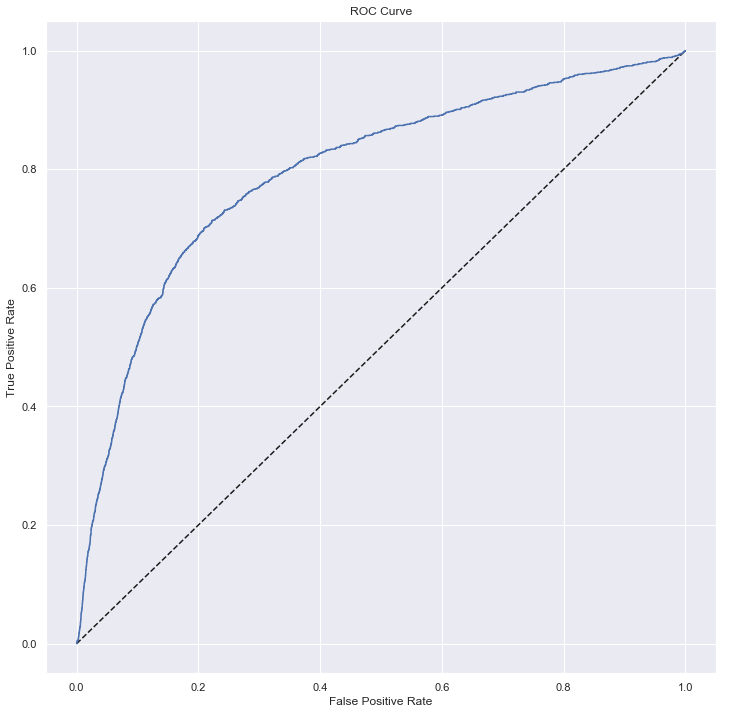

In [721]:
# ROC Curve
logreg.fit(X_r3, y_r3) # Fit the classifier to the training data

y_pred_prob = logreg.predict_proba(X_test_2)[:,1]

auc_score = roc_auc_score(y_test_2, y_pred_prob)
print('ROC AUC Score: ' + str(auc_score))
print()

fpr, tpr, thresholds = roc_curve(y_test_2, y_pred_prob) # False Positive, True Positive, Threshold

plt.figure(figsize=(12,12))
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()


### Metrics by Subgroups
The Count % vs. Actual Stop % vs. Predicted Stop % graph is showing Logistic Regression overpredicting stops when there are 13 or less payments made.  If someone has made 4 or less payments, that person has over a 50% chance of being predicted as a Stop.

In [722]:
X_test2 = pd.DataFrame(X_test_2)
y_test2 = pd.DataFrame(y_test_2)
y_test2['pred'] = y_pred
y_test2[:][y_test2['pred']==1]

# Merging the X_test2 and y_test2 together.
df3 = pd.concat([X_test2, y_test2.reindex(X_test2.index)], axis=1) 


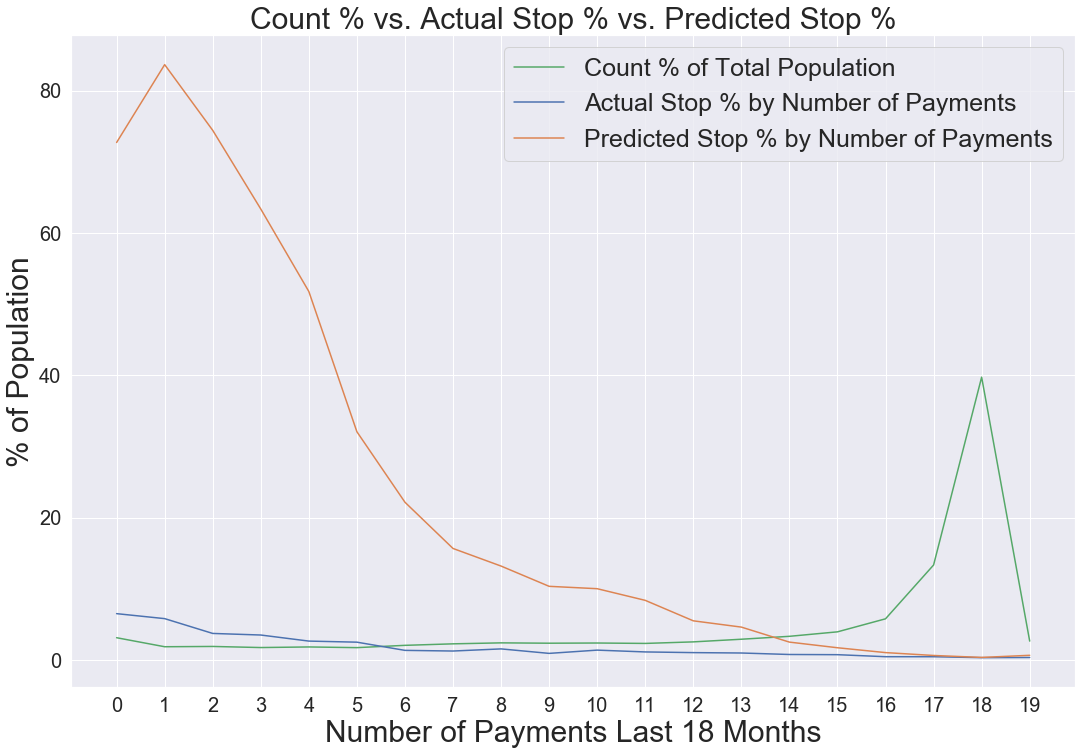

In [723]:
plt.figure(figsize=(18,12))
data = df3['PAYMENTS_IN_LAST_18_MONTHS'][df3['PAYMENTS_IN_LAST_18_MONTHS'] < 20].groupby(df3['PAYMENTS_IN_LAST_18_MONTHS']).count()
x1 = list(np.unique(df3['PAYMENTS_IN_LAST_18_MONTHS'][df3['PAYMENTS_IN_LAST_18_MONTHS'] < 20]))
y1 = (data/data.sum())*100
data2 = df3['PAYMENTS_IN_LAST_18_MONTHS'][((df3['STOP_21_DAYS_FROM_20190301'] == 1)& (df3['PAYMENTS_IN_LAST_18_MONTHS'] < 20))].groupby(df3['PAYMENTS_IN_LAST_18_MONTHS']).count()
y2 = (data2/data)*100

data3 = df3['PAYMENTS_IN_LAST_18_MONTHS'][((df3['pred'] == 1) & (df3['PAYMENTS_IN_LAST_18_MONTHS'] < 20))].groupby(df3['PAYMENTS_IN_LAST_18_MONTHS']).count()
y3 = (data3/data)*100
plt.xlabel('Number of Payments Last 18 Months', fontsize=30)
plt.ylabel('% of Population', fontsize=30)
plt.title('Count % vs. Actual Stop % vs. Predicted Stop %', fontsize=30)

plt.plot(x1, y1, color='g', label='Count % of Total Population')
plt.plot(x1, y2, label='Actual Stop % by Number of Payments')
plt.plot(x1, y3, label='Predicted Stop % by Number of Payments')
plt.xticks(np.arange(0,20,1),fontsize=20)
plt.yticks( fontsize=20)
plt.legend(loc=1, prop={'size': 25})

plt.show()

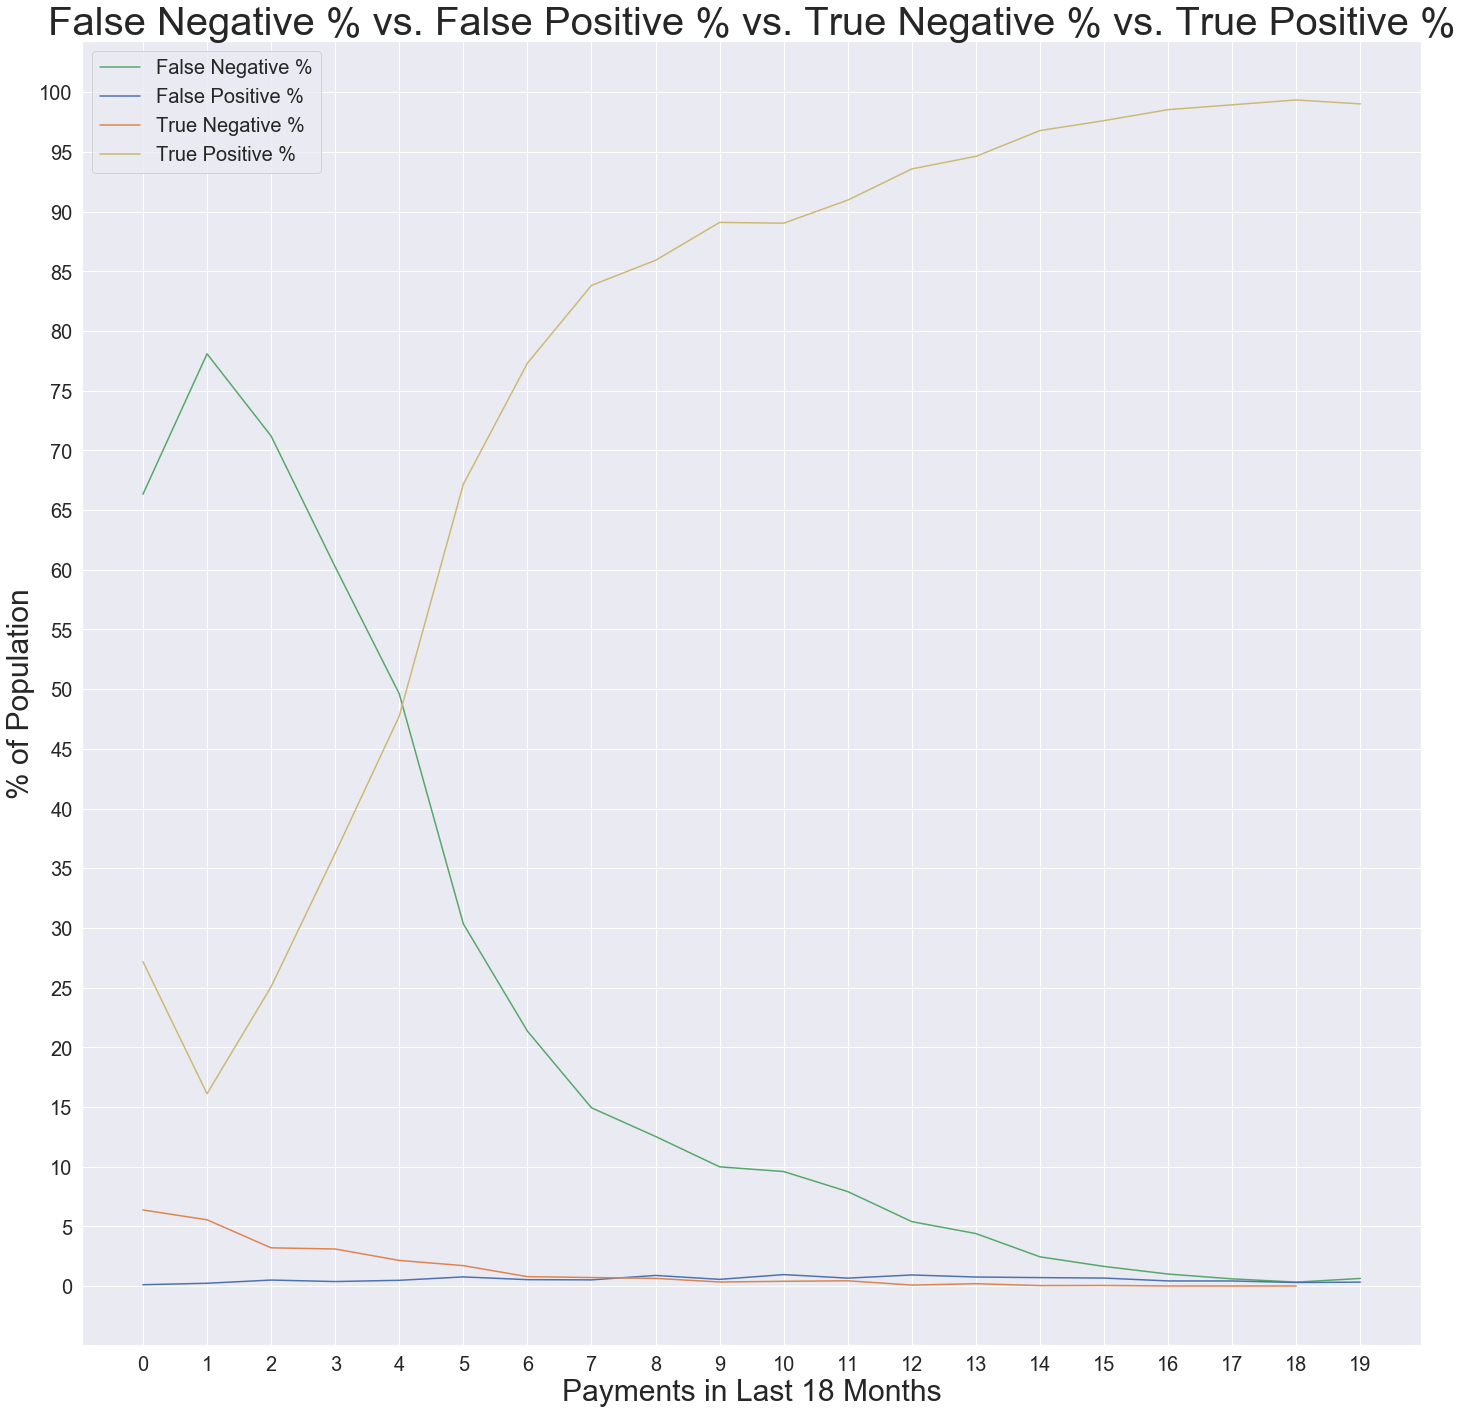

In [724]:

plt.figure(figsize=(24,24))

# False Negative
data1 = df3['PAYMENTS_IN_LAST_18_MONTHS'][(df3['STOP_21_DAYS_FROM_20190301'] == 0) & (df3['pred'] == 1) & (df3['PAYMENTS_IN_LAST_18_MONTHS'] < 20)].groupby(df3['PAYMENTS_IN_LAST_18_MONTHS']).count()
x1 = list(np.unique(df3['PAYMENTS_IN_LAST_18_MONTHS'][(df3['STOP_21_DAYS_FROM_20190301'] == 0) & (df3['pred'] == 1) & (df3['PAYMENTS_IN_LAST_18_MONTHS'] < 20)]))
y1 = (data1/data)*100
y1 = y1.dropna()

# False Positive
data2 = df3['PAYMENTS_IN_LAST_18_MONTHS'][(df3['STOP_21_DAYS_FROM_20190301'] == 1) & (df3['pred'] == 0) & (df3['PAYMENTS_IN_LAST_18_MONTHS'] < 20)].groupby(df3['PAYMENTS_IN_LAST_18_MONTHS']).count()
x2 = list(np.unique(df3['PAYMENTS_IN_LAST_18_MONTHS'][(df3['STOP_21_DAYS_FROM_20190301'] == 1) & (df3['pred'] == 0) & (df3['PAYMENTS_IN_LAST_18_MONTHS'] < 20)]))
y2 = (data2/data)*100
y2 = y2.dropna()

# True Negative
data3 = df3['PAYMENTS_IN_LAST_18_MONTHS'][(df3['STOP_21_DAYS_FROM_20190301'] == 1) & (df3['pred'] == 1) & (df3['PAYMENTS_IN_LAST_18_MONTHS'] < 20)].groupby(df3['PAYMENTS_IN_LAST_18_MONTHS']).count()
x3 = list(np.unique(df3['PAYMENTS_IN_LAST_18_MONTHS'][(df3['STOP_21_DAYS_FROM_20190301'] == 1) & (df3['pred'] == 1) & (df3['PAYMENTS_IN_LAST_18_MONTHS'] < 20)]))
y3 = (data3/data)*100
y3 = y3.dropna()

# True Positive
data4 = df3['PAYMENTS_IN_LAST_18_MONTHS'][(df3['STOP_21_DAYS_FROM_20190301'] == 0) & (df3['pred'] == 0) & (df3['PAYMENTS_IN_LAST_18_MONTHS'] < 20)].groupby(df3['PAYMENTS_IN_LAST_18_MONTHS']).count()
x4 = list(np.unique(df3['PAYMENTS_IN_LAST_18_MONTHS'][(df3['STOP_21_DAYS_FROM_20190301'] == 0) & (df3['pred'] == 0) & (df3['PAYMENTS_IN_LAST_18_MONTHS'] < 20)]))
y4 = (data4/data)*100
y4 = y4.dropna()

plt.xlabel('Payments in Last 18 Months', fontsize=30)
plt.ylabel('% of Population', fontsize=30)
plt.title('False Negative % vs. False Positive % vs. True Negative % vs. True Positive %', fontsize=40)

plt.plot(x1, y1, color='g', label='False Negative %')
plt.plot(x2, y2, label='False Positive %')
plt.plot(x3, y3, label='True Negative %')
plt.plot(x4, y4, color='y', label='True Positive %')
plt.xticks(np.arange(0,20), fontsize=20)
plt.yticks(np.arange(0,105,5), fontsize=20) 
plt.legend(loc=0, prop={'size': 20})

plt.show()


## Logistic Regression (Balanced)

### Using the upsampling of 20k stops and downsampling of 40k active
The Confusion Matrix is showing:
* Accuracy: 71% (96,409 out of 136,480)
* Precision: 99% (tp / (tp + fp))
* Recall: 71% (tp / (tp + fn))
* F1 Score: 83% (2 * ((p * r) / (p + r)))
<br>

The confusion matrix is showing bad numbers but looking at the total savings from the custom scorer shows that the company would lose over 292,000 dollars using this algorithm.
* Predicted 1,044 Stops out of 1,403 (74%)
* Out of the 40,756 predicted stops, only 1043 were actual stops (3%)
<br><br>

<b>Total Savings: -292,720</b>

In [725]:
# Cross Validation w/ Balance
n_CV = 10

penalty = ['l1', 'l2'] # regularization penablty space
C = np.logspace(0, 4, 3) # regularization hyperparameter space
param_grid = dict(C=C, penalty=penalty)

logreg = LogisticRegression(solver='liblinear', class_weight='balanced') # Create the classifier

logreg_cv = GridSearchCV(logreg, param_grid, cv=n_CV, scoring=savings_scorer, n_jobs=-1) # 5 fold

logreg_cv.fit(X_r3, y_r3) # Fit the classifier to the training data

y_pred = logreg_cv.predict(X_test_2) # Predict the labels of the test set

print_stats(y_test_2, y_pred)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Confusion Matrix:
[[95365 39712]
 [  359  1044]]


Total Savings -292720


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.71      0.83    135077
           1       0.03      0.74      0.05      1403

   micro avg       0.71      0.71      0.71    136480
   macro avg       0.51      0.73      0.44    136480
weighted avg       0.99      0.71      0.82    136480


Accuracy Score: 0.7063965416178195


#### ROC Curve of Balanced Logistic Regression

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


ROC AUC Score: 0.7783700794696277



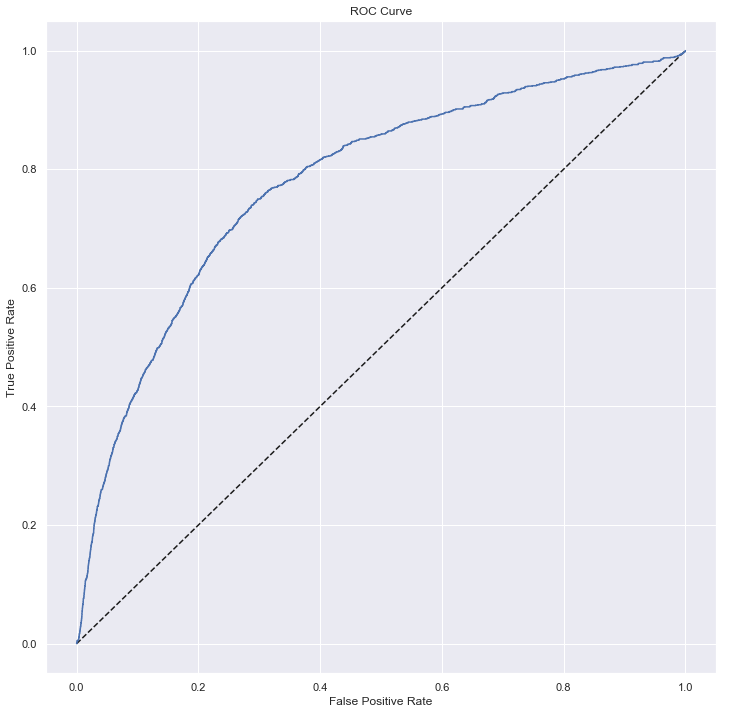

In [726]:
# ROC Curve
logreg.fit(X_r3, y_r3) # Fit the classifier to the training data

y_pred_prob = logreg.predict_proba(X_test_2)[:,1]

auc_score = roc_auc_score(y_test_2, y_pred_prob)
print('ROC AUC Score: ' + str(auc_score))
print()

fpr, tpr, thresholds = roc_curve(y_test_2, y_pred_prob) # False Positive, True Positive, Threshold

plt.figure(figsize=(12,12))
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()


### Metrics by Subgroups for Logistic Regression (Balanced)

The Count % vs. Actual Stop % vs. Predicted Stop % graph is showing Logistic Regression with Balanced Class Weight overpredicting all stops where the customer has made 17 or less payments.  If someone has made 9 or less payments, that person has over a 50% chance of being predicted as a Stop.

In [727]:
X_test2 = pd.DataFrame(X_test_2)
y_test2 = pd.DataFrame(y_test_2)
y_test2['pred'] = y_pred
y_test2[:][y_test2['pred']==1]

# Merging the X_test2 and y_test2 together.
df3 = pd.concat([X_test2, y_test2.reindex(X_test2.index)], axis=1) 


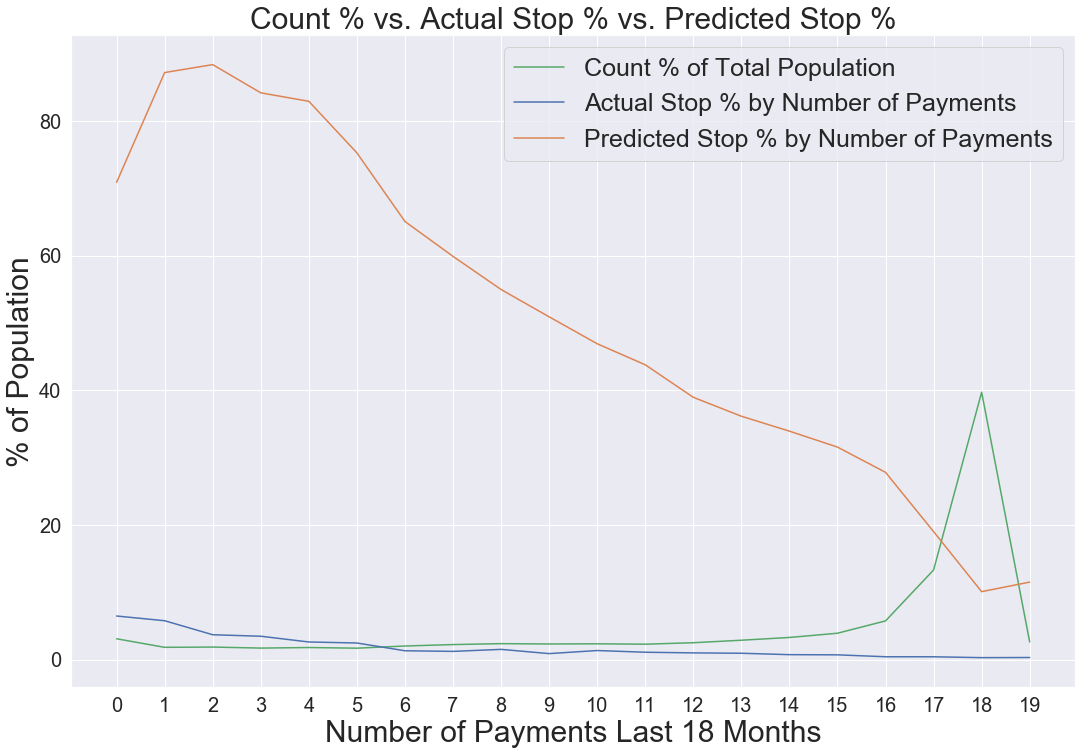

In [728]:

plt.figure(figsize=(18,12))
data = df3['PAYMENTS_IN_LAST_18_MONTHS'][df3['PAYMENTS_IN_LAST_18_MONTHS'] < 20].groupby(df3['PAYMENTS_IN_LAST_18_MONTHS']).count()
x1 = list(np.unique(df3['PAYMENTS_IN_LAST_18_MONTHS'][df3['PAYMENTS_IN_LAST_18_MONTHS'] < 20]))
y1 = (data/data.sum())*100
data2 = df3['PAYMENTS_IN_LAST_18_MONTHS'][((df3['STOP_21_DAYS_FROM_20190301'] == 1)& (df3['PAYMENTS_IN_LAST_18_MONTHS'] < 20))].groupby(df3['PAYMENTS_IN_LAST_18_MONTHS']).count()
y2 = (data2/data)*100

data3 = df3['PAYMENTS_IN_LAST_18_MONTHS'][((df3['pred'] == 1) & (df3['PAYMENTS_IN_LAST_18_MONTHS'] < 20))].groupby(df3['PAYMENTS_IN_LAST_18_MONTHS']).count()
y3 = (data3/data)*100
plt.xlabel('Number of Payments Last 18 Months', fontsize=30)
plt.ylabel('% of Population', fontsize=30)
plt.title('Count % vs. Actual Stop % vs. Predicted Stop %', fontsize=30)

plt.plot(x1, y1, color='g', label='Count % of Total Population')
plt.plot(x1, y2, label='Actual Stop % by Number of Payments')
plt.plot(x1, y3, label='Predicted Stop % by Number of Payments')
plt.xticks(np.arange(0,20,1),fontsize=20)
plt.yticks( fontsize=20)
plt.legend(loc=1, prop={'size': 25})

plt.show()

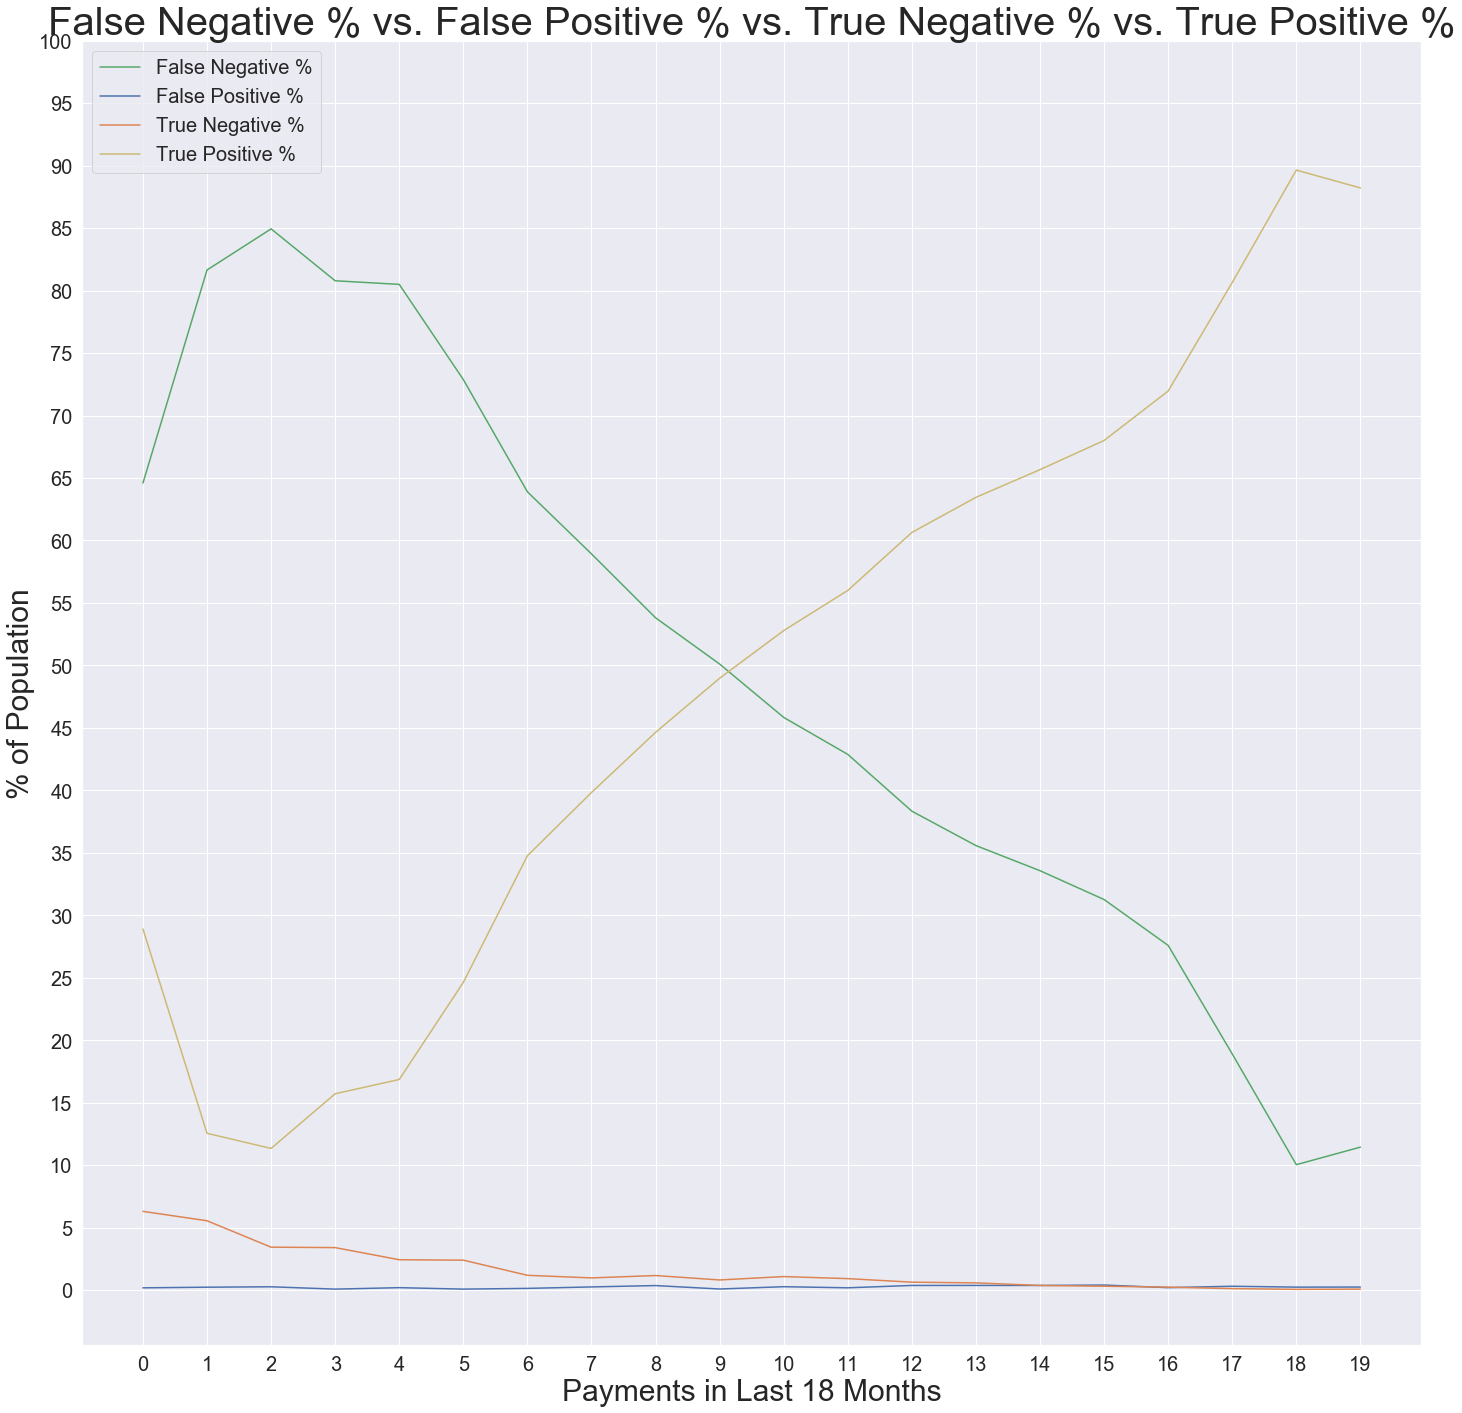

In [729]:

plt.figure(figsize=(24,24))

# False Negative
data1 = df3['PAYMENTS_IN_LAST_18_MONTHS'][(df3['STOP_21_DAYS_FROM_20190301'] == 0) & (df3['pred'] == 1) & (df3['PAYMENTS_IN_LAST_18_MONTHS'] < 20)].groupby(df3['PAYMENTS_IN_LAST_18_MONTHS']).count()
x1 = list(np.unique(df3['PAYMENTS_IN_LAST_18_MONTHS'][(df3['STOP_21_DAYS_FROM_20190301'] == 0) & (df3['pred'] == 1) & (df3['PAYMENTS_IN_LAST_18_MONTHS'] < 20)]))
y1 = (data1/data)*100
y1 = y1.dropna()

# False Positive
data2 = df3['PAYMENTS_IN_LAST_18_MONTHS'][(df3['STOP_21_DAYS_FROM_20190301'] == 1) & (df3['pred'] == 0) & (df3['PAYMENTS_IN_LAST_18_MONTHS'] < 20)].groupby(df3['PAYMENTS_IN_LAST_18_MONTHS']).count()
x2 = list(np.unique(df3['PAYMENTS_IN_LAST_18_MONTHS'][(df3['STOP_21_DAYS_FROM_20190301'] == 1) & (df3['pred'] == 0) & (df3['PAYMENTS_IN_LAST_18_MONTHS'] < 20)]))
y2 = (data2/data)*100
y2 = y2.dropna()

# True Negative
data3 = df3['PAYMENTS_IN_LAST_18_MONTHS'][(df3['STOP_21_DAYS_FROM_20190301'] == 1) & (df3['pred'] == 1) & (df3['PAYMENTS_IN_LAST_18_MONTHS'] < 20)].groupby(df3['PAYMENTS_IN_LAST_18_MONTHS']).count()
x3 = list(np.unique(df3['PAYMENTS_IN_LAST_18_MONTHS'][(df3['STOP_21_DAYS_FROM_20190301'] == 1) & (df3['pred'] == 1) & (df3['PAYMENTS_IN_LAST_18_MONTHS'] < 20)]))
y3 = (data3/data)*100
y3 = y3.dropna()

# True Positive
data4 = df3['PAYMENTS_IN_LAST_18_MONTHS'][(df3['STOP_21_DAYS_FROM_20190301'] == 0) & (df3['pred'] == 0) & (df3['PAYMENTS_IN_LAST_18_MONTHS'] < 20)].groupby(df3['PAYMENTS_IN_LAST_18_MONTHS']).count()
x4 = list(np.unique(df3['PAYMENTS_IN_LAST_18_MONTHS'][(df3['STOP_21_DAYS_FROM_20190301'] == 0) & (df3['pred'] == 0) & (df3['PAYMENTS_IN_LAST_18_MONTHS'] < 20)]))
y4 = (data4/data)*100
y4 = y4.dropna()

plt.xlabel('Payments in Last 18 Months', fontsize=30)
plt.ylabel('% of Population', fontsize=30)
plt.title('False Negative % vs. False Positive % vs. True Negative % vs. True Positive %', fontsize=40)

plt.plot(x1, y1, color='g', label='False Negative %')
plt.plot(x2, y2, label='False Positive %')
plt.plot(x3, y3, label='True Negative %')
plt.plot(x4, y4, color='y', label='True Positive %')
plt.xticks(np.arange(0,20), fontsize=20)
plt.yticks(np.arange(0,105,5), fontsize=20) 
plt.legend(loc=0, prop={'size': 20})

plt.show()


## k-NN


### Using the upsampling of 20k stops and downsampling of 40k active
The Confusion Matrix is showing:
* Accuracy: 95% (129,805 out of 136,480)
* Precision: 99% (tp / (tp + fp))
* Recall: 96% (tp / (tp + fn))
* F1 Score: 97% (2 * ((p * r) / (p + r)))
<br>

The confusion matrix is showing pretty good numbers but looking at the total savings from the custom scorer shows that the company would lose over 26,000 dollars using this algorithm.
* Predicted 294 Stops out of 1,403 (21%)
* Out of the 5,860 predicted stops, only 294 were actual stops (5%)
<br><br>

<b>Total Savings: -26,260</b>

In [730]:
# Get the best param #
n_CV = 5

param_grid = {'n_neighbors': np.arange(1,12)}

knn = KNeighborsClassifier()

# print_cv_scores(knn, X_test_2, y_test_2, savings_scorer, n_CV, -1) # Print cross_val_score using custom scoring 

knn_cv = GridSearchCV(knn, param_grid, cv=n_CV, scoring=savings_scorer, n_jobs=-1) # 5 fold

knn_cv.fit(X_r3, y_r3)

knn_neighbors = knn_cv.best_params_

CV Scores:
[-1710 -2150 -2150 -2250 -1700]

Accuracy: -1992.00 (+/- 474.37)

Total Savings: -9960.0



Using the best k-nn value and uniform weight.

In [731]:
knn = KNeighborsClassifier(n_neighbors=knn_neighbors['n_neighbors'], weights='uniform')

# print_cv_scores(knn, X_test_2, y_test_2, savings_scorer, n_CV, -1) # Print cross_val_score using custom scoring 
# print_cv_scores(knn, X, y, savings_scorer, n_CV, -1) # Print cross_val_score using custom scoring 

knn.fit(X_r3, y_r3)

y_pred = knn.predict(X_test_2)

# print('Prediction: {}'.format(y_pred))
print('k-NN Score: {}'.format(knn.score(X_test_2, y_test_2)))
print()
print_stats(y_test_2, y_pred)

k-NN Score: 0.951091735052755

Confusion Matrix:
[[129511   5566]
 [  1109    294]]


Total Savings -26260


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97    135077
           1       0.05      0.21      0.08      1403

   micro avg       0.95      0.95      0.95    136480
   macro avg       0.52      0.58      0.53    136480
weighted avg       0.98      0.95      0.97    136480


Accuracy Score: 0.951091735052755


ROC Curve 

ROC AUC Score: 0.5841724176740121



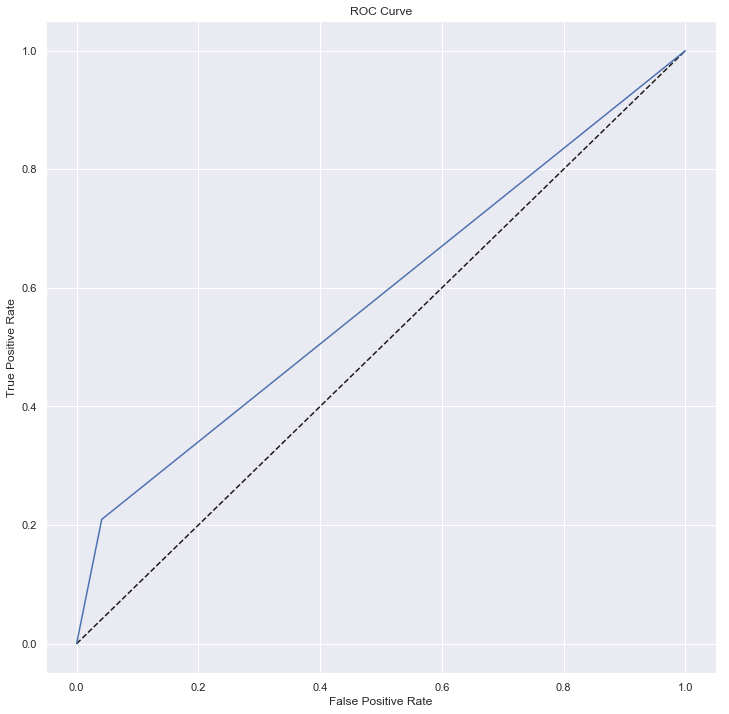

In [732]:
# ROC Curve
y_r_pred_prob = knn.predict_proba(X_test_2)[:,1]

auc_score = roc_auc_score(y_test_2, y_r_pred_prob)
print('ROC AUC Score: ' + str(auc_score))
print()

fpr, tpr, thresholds = roc_curve(y_test_2, y_r_pred_prob) # False Positive, True Positive, Threshold

plt.figure(figsize=(12,12))
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()


### Metrics by Subgroups for k-NN

The Count % vs. Actual Stop % vs. Predicted Stop % graph is showing the algorithm greatly overpredicting all stops where the customer has made 14 or less payments.  The highest predicted population % predicted to be stops were customers who have made 1 payment.  The predicted % is around 18%.

In [733]:
X_test2 = pd.DataFrame(X_test_2)
y_test2 = pd.DataFrame(y_test_2)
y_test2['pred'] = y_pred
y_test2[:][y_test2['pred']==1]

# Merging the X_test2 and y_test2 together.
df3 = pd.concat([X_test2, y_test2.reindex(X_test2.index)], axis=1) 


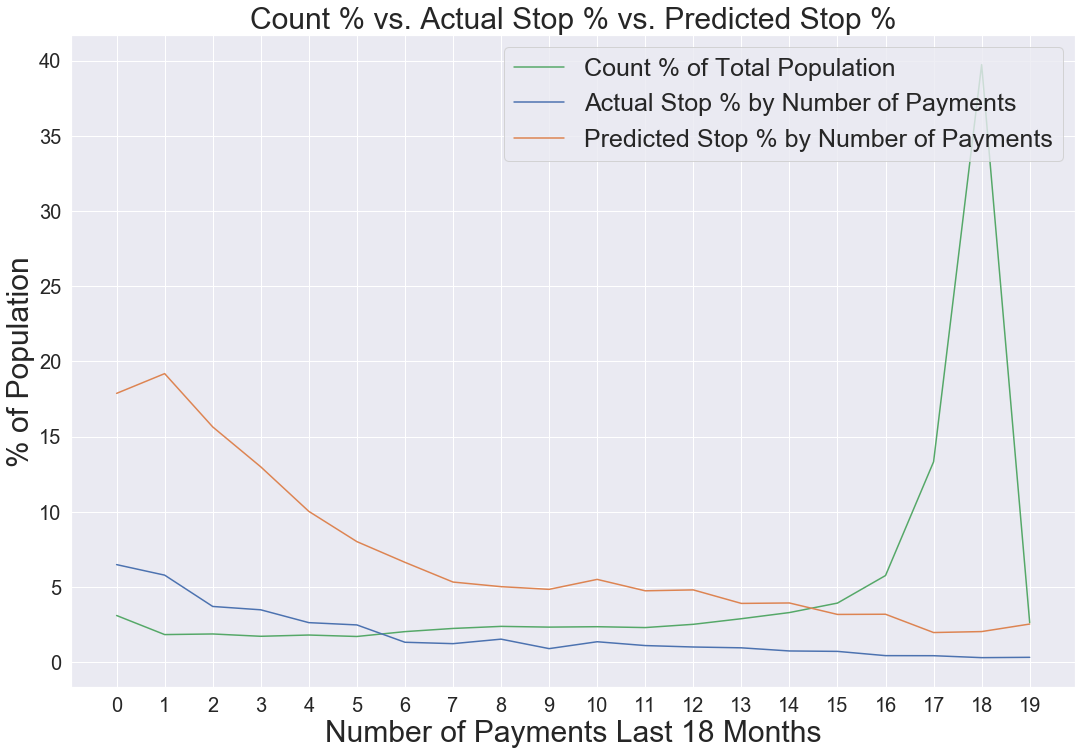

In [734]:

plt.figure(figsize=(18,12))
data = df3['PAYMENTS_IN_LAST_18_MONTHS'][df3['PAYMENTS_IN_LAST_18_MONTHS'] < 20].groupby(df3['PAYMENTS_IN_LAST_18_MONTHS']).count()
x1 = list(np.unique(df3['PAYMENTS_IN_LAST_18_MONTHS'][df3['PAYMENTS_IN_LAST_18_MONTHS'] < 20]))
y1 = (data/data.sum())*100
data2 = df3['PAYMENTS_IN_LAST_18_MONTHS'][((df3['STOP_21_DAYS_FROM_20190301'] == 1)& (df3['PAYMENTS_IN_LAST_18_MONTHS'] < 20))].groupby(df3['PAYMENTS_IN_LAST_18_MONTHS']).count()
y2 = (data2/data)*100

data3 = df3['PAYMENTS_IN_LAST_18_MONTHS'][((df3['pred'] == 1) & (df3['PAYMENTS_IN_LAST_18_MONTHS'] < 20))].groupby(df3['PAYMENTS_IN_LAST_18_MONTHS']).count()
y3 = (data3/data)*100
plt.xlabel('Number of Payments Last 18 Months', fontsize=30)
plt.ylabel('% of Population', fontsize=30)
plt.title('Count % vs. Actual Stop % vs. Predicted Stop %', fontsize=30)

plt.plot(x1, y1, color='g', label='Count % of Total Population')
plt.plot(x1, y2, label='Actual Stop % by Number of Payments')
plt.plot(x1, y3, label='Predicted Stop % by Number of Payments')
plt.xticks(np.arange(0,20,1),fontsize=20)
plt.yticks( fontsize=20)
plt.legend(loc=1, prop={'size': 25})

plt.show()

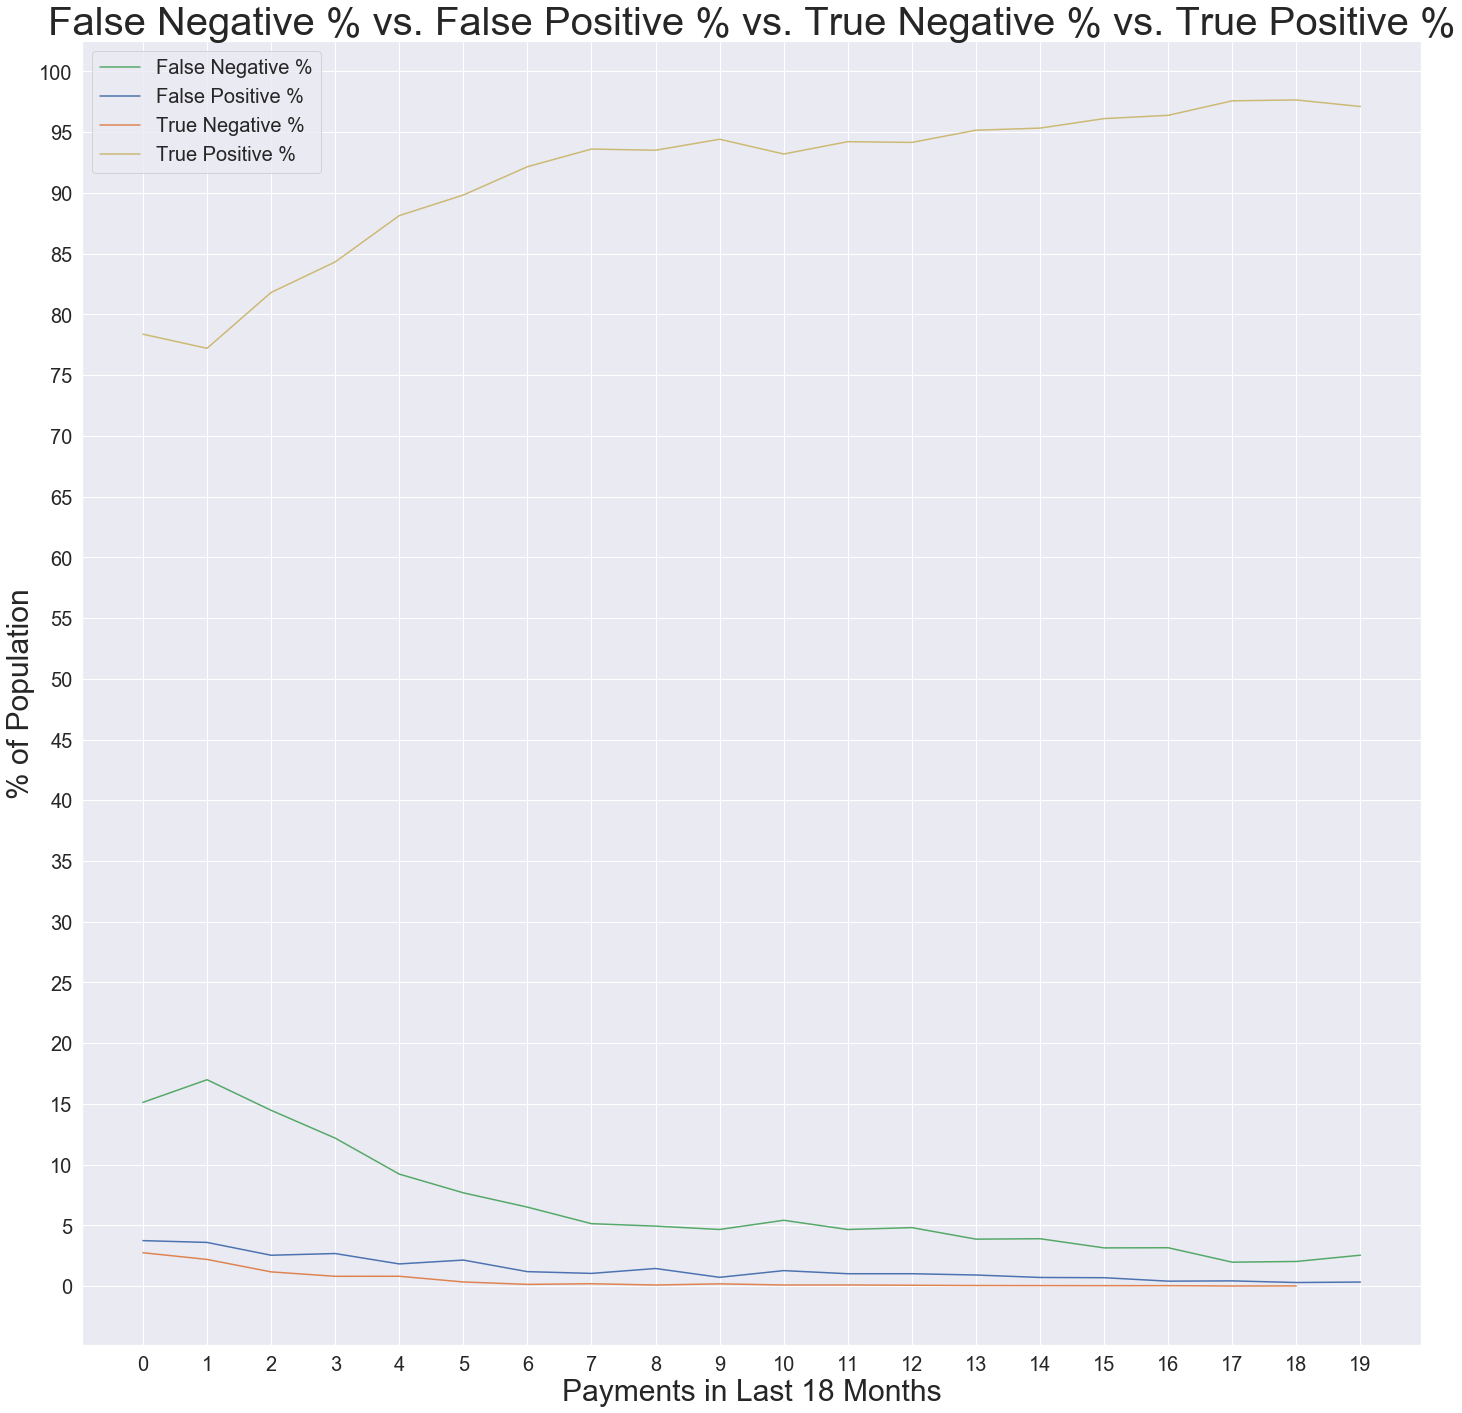

In [735]:

plt.figure(figsize=(24,24))

# False Negative
data1 = df3['PAYMENTS_IN_LAST_18_MONTHS'][(df3['STOP_21_DAYS_FROM_20190301'] == 0) & (df3['pred'] == 1) & (df3['PAYMENTS_IN_LAST_18_MONTHS'] < 20)].groupby(df3['PAYMENTS_IN_LAST_18_MONTHS']).count()
x1 = list(np.unique(df3['PAYMENTS_IN_LAST_18_MONTHS'][(df3['STOP_21_DAYS_FROM_20190301'] == 0) & (df3['pred'] == 1) & (df3['PAYMENTS_IN_LAST_18_MONTHS'] < 20)]))
y1 = (data1/data)*100
y1 = y1.dropna()

# False Positive
data2 = df3['PAYMENTS_IN_LAST_18_MONTHS'][(df3['STOP_21_DAYS_FROM_20190301'] == 1) & (df3['pred'] == 0) & (df3['PAYMENTS_IN_LAST_18_MONTHS'] < 20)].groupby(df3['PAYMENTS_IN_LAST_18_MONTHS']).count()
x2 = list(np.unique(df3['PAYMENTS_IN_LAST_18_MONTHS'][(df3['STOP_21_DAYS_FROM_20190301'] == 1) & (df3['pred'] == 0) & (df3['PAYMENTS_IN_LAST_18_MONTHS'] < 20)]))
y2 = (data2/data)*100
y2 = y2.dropna()

# True Negative
data3 = df3['PAYMENTS_IN_LAST_18_MONTHS'][(df3['STOP_21_DAYS_FROM_20190301'] == 1) & (df3['pred'] == 1) & (df3['PAYMENTS_IN_LAST_18_MONTHS'] < 20)].groupby(df3['PAYMENTS_IN_LAST_18_MONTHS']).count()
x3 = list(np.unique(df3['PAYMENTS_IN_LAST_18_MONTHS'][(df3['STOP_21_DAYS_FROM_20190301'] == 1) & (df3['pred'] == 1) & (df3['PAYMENTS_IN_LAST_18_MONTHS'] < 20)]))
y3 = (data3/data)*100
y3 = y3.dropna()

# True Positive
data4 = df3['PAYMENTS_IN_LAST_18_MONTHS'][(df3['STOP_21_DAYS_FROM_20190301'] == 0) & (df3['pred'] == 0) & (df3['PAYMENTS_IN_LAST_18_MONTHS'] < 20)].groupby(df3['PAYMENTS_IN_LAST_18_MONTHS']).count()
x4 = list(np.unique(df3['PAYMENTS_IN_LAST_18_MONTHS'][(df3['STOP_21_DAYS_FROM_20190301'] == 0) & (df3['pred'] == 0) & (df3['PAYMENTS_IN_LAST_18_MONTHS'] < 20)]))
y4 = (data4/data)*100
y4 = y4.dropna()

plt.xlabel('Payments in Last 18 Months', fontsize=30)
plt.ylabel('% of Population', fontsize=30)
plt.title('False Negative % vs. False Positive % vs. True Negative % vs. True Positive %', fontsize=40)

plt.plot(x1, y1, color='g', label='False Negative %')
plt.plot(x2, y2, label='False Positive %')
plt.plot(x3, y3, label='True Negative %')
plt.plot(x4, y4, color='y', label='True Positive %')
plt.xticks(np.arange(0,20), fontsize=20)
plt.yticks(np.arange(0,105,5), fontsize=20) 
plt.legend(loc=0, prop={'size': 20})

plt.show()


## Random Forest

### Using the upsampling of 20k stops and downsampling of 40k active
Running the Confusion Matrix for all features is showing:
* Accuracy: 98% (134,023 out of 136,480)
* Precision: 99% (tp / (tp + fp))
* Recall: 99% (tp / (tp + fn))
* F1 Score: 99% (2 * ((p * r) / (p + r)))
<br>

The confusion matrix is showing pretty great numbers compared to the other models and looking at the total savings from the custom scorer shows that the company would save over 24,000 dollars using this algorithm.
* Predicted 390 Stops out of 1,403 (28%)
* Out of the 1,834 predicted stops, 390 were actual stops (21%)
<br><br>

<b>Total Savings: 24,560</b>

In [760]:
# Feature Importance

features = X_r3.keys() # Store Feature Names

clf = RandomForestClassifier(n_estimators=1000,  random_state=50, n_jobs=-1) # 1000 Trees
clf.fit(X_r3, y_r3)

y_pred = clf.predict(X_test_2)

print_stats(y_test_2, y_pred)

Confusion Matrix:
[[133633   1444]
 [  1013    390]]


Total Savings 24560


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    135077
           1       0.21      0.28      0.24      1403

   micro avg       0.98      0.98      0.98    136480
   macro avg       0.60      0.63      0.62    136480
weighted avg       0.98      0.98      0.98    136480


Accuracy Score: 0.9819973622508793


### Metrics by Subgroups for Random Forest

The Count % vs. Actual Stop % vs. Predicted Stop % graph is showing Random Forest making the best predictions seen yet.  5 or less payments are overpredicted to stop but not by much.  The biggest % overprediction is 0 payments and that is about 10% overpredicted.  

In [737]:
X_test2 = pd.DataFrame(X_test_2)
y_test2 = pd.DataFrame(y_test_2)
y_test2['pred'] = y_pred
y_test2[:][y_test2['pred']==1]

# Merging the X_test2 and y_test2 together.
df3 = pd.concat([X_test2, y_test2.reindex(X_test2.index)], axis=1) 


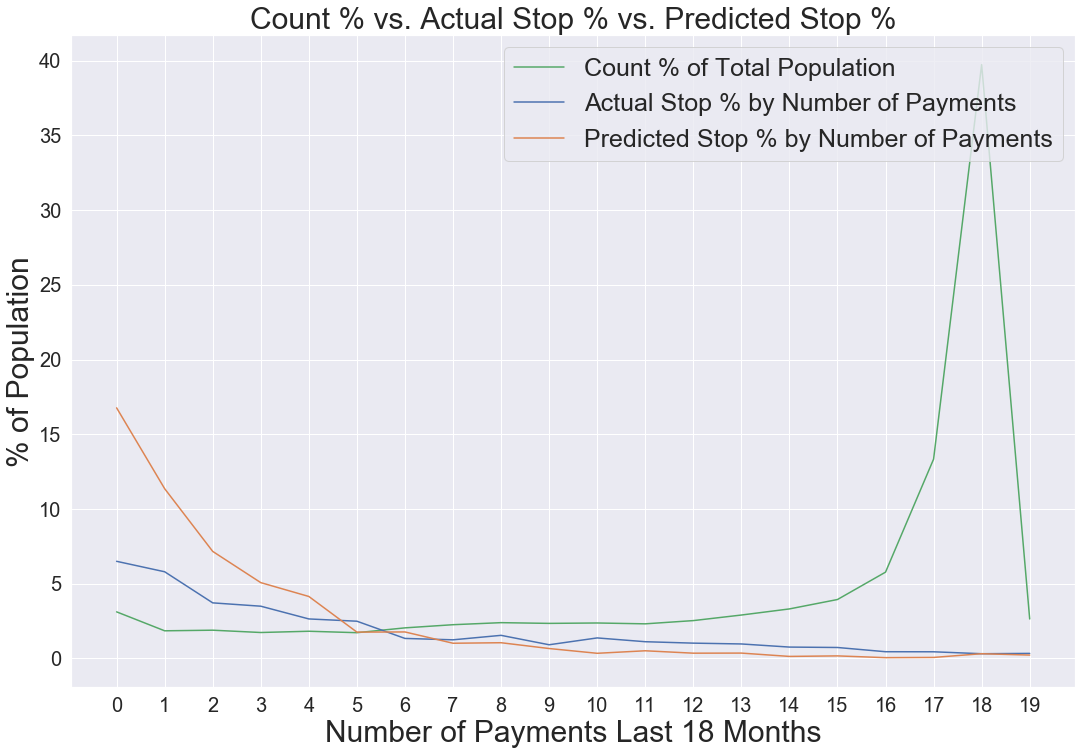

In [738]:

plt.figure(figsize=(18,12))
data = df3['PAYMENTS_IN_LAST_18_MONTHS'][df3['PAYMENTS_IN_LAST_18_MONTHS'] < 20].groupby(df3['PAYMENTS_IN_LAST_18_MONTHS']).count()
x1 = list(np.unique(df3['PAYMENTS_IN_LAST_18_MONTHS'][df3['PAYMENTS_IN_LAST_18_MONTHS'] < 20]))
y1 = (data/data.sum())*100
data2 = df3['PAYMENTS_IN_LAST_18_MONTHS'][((df3['STOP_21_DAYS_FROM_20190301'] == 1)& (df3['PAYMENTS_IN_LAST_18_MONTHS'] < 20))].groupby(df3['PAYMENTS_IN_LAST_18_MONTHS']).count()
y2 = (data2/data)*100

data3 = df3['PAYMENTS_IN_LAST_18_MONTHS'][((df3['pred'] == 1) & (df3['PAYMENTS_IN_LAST_18_MONTHS'] < 20))].groupby(df3['PAYMENTS_IN_LAST_18_MONTHS']).count()
y3 = (data3/data)*100
plt.xlabel('Number of Payments Last 18 Months', fontsize=30)
plt.ylabel('% of Population', fontsize=30)
plt.title('Count % vs. Actual Stop % vs. Predicted Stop %', fontsize=30)

plt.plot(x1, y1, color='g', label='Count % of Total Population')
plt.plot(x1, y2, label='Actual Stop % by Number of Payments')
plt.plot(x1, y3, label='Predicted Stop % by Number of Payments')
plt.xticks(np.arange(0,20,1),fontsize=20)
plt.yticks( fontsize=20)
plt.legend(loc=1, prop={'size': 25})

plt.show()

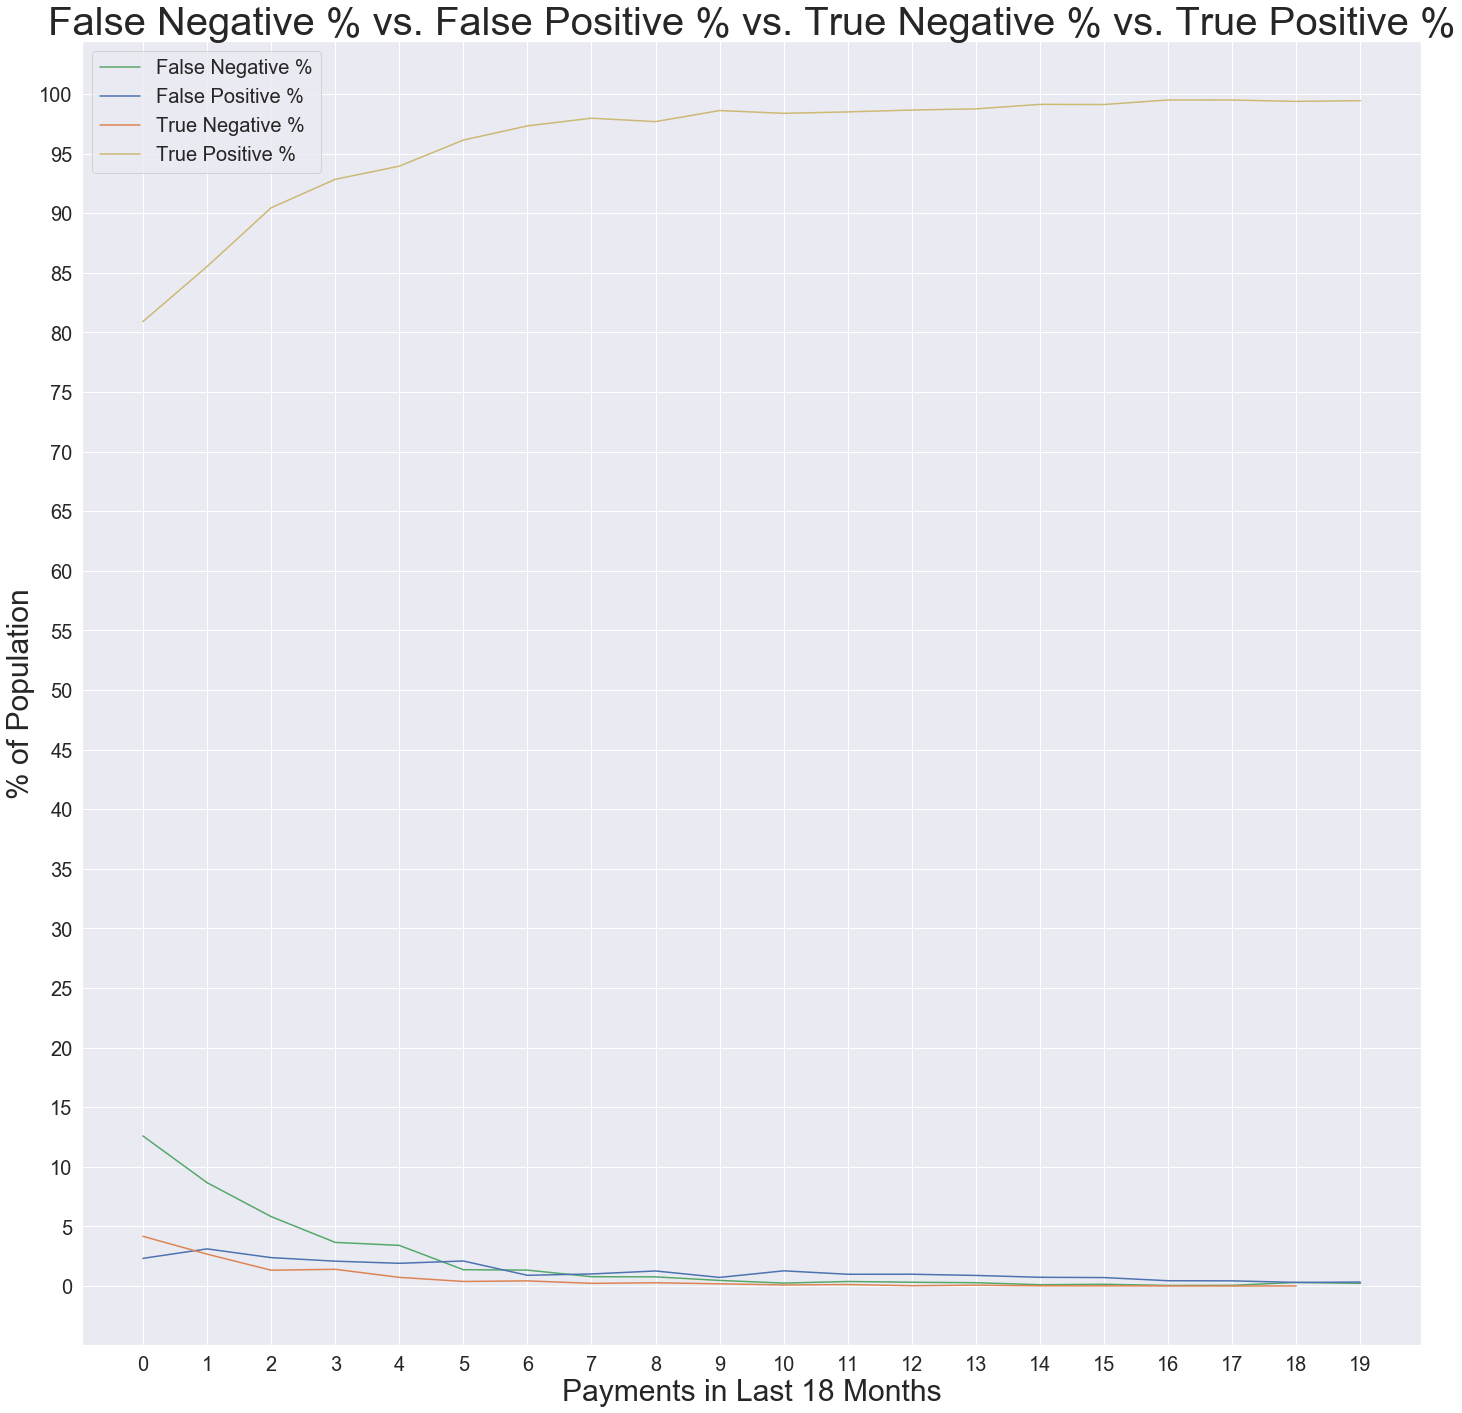

In [739]:

plt.figure(figsize=(24,24))

# False Negative
data1 = df3['PAYMENTS_IN_LAST_18_MONTHS'][(df3['STOP_21_DAYS_FROM_20190301'] == 0) & (df3['pred'] == 1) & (df3['PAYMENTS_IN_LAST_18_MONTHS'] < 20)].groupby(df3['PAYMENTS_IN_LAST_18_MONTHS']).count()
x1 = list(np.unique(df3['PAYMENTS_IN_LAST_18_MONTHS'][(df3['STOP_21_DAYS_FROM_20190301'] == 0) & (df3['pred'] == 1) & (df3['PAYMENTS_IN_LAST_18_MONTHS'] < 20)]))
y1 = (data1/data)*100
y1 = y1.dropna()

# False Positive
data2 = df3['PAYMENTS_IN_LAST_18_MONTHS'][(df3['STOP_21_DAYS_FROM_20190301'] == 1) & (df3['pred'] == 0) & (df3['PAYMENTS_IN_LAST_18_MONTHS'] < 20)].groupby(df3['PAYMENTS_IN_LAST_18_MONTHS']).count()
x2 = list(np.unique(df3['PAYMENTS_IN_LAST_18_MONTHS'][(df3['STOP_21_DAYS_FROM_20190301'] == 1) & (df3['pred'] == 0) & (df3['PAYMENTS_IN_LAST_18_MONTHS'] < 20)]))
y2 = (data2/data)*100
y2 = y2.dropna()

# True Negative
data3 = df3['PAYMENTS_IN_LAST_18_MONTHS'][(df3['STOP_21_DAYS_FROM_20190301'] == 1) & (df3['pred'] == 1) & (df3['PAYMENTS_IN_LAST_18_MONTHS'] < 20)].groupby(df3['PAYMENTS_IN_LAST_18_MONTHS']).count()
x3 = list(np.unique(df3['PAYMENTS_IN_LAST_18_MONTHS'][(df3['STOP_21_DAYS_FROM_20190301'] == 1) & (df3['pred'] == 1) & (df3['PAYMENTS_IN_LAST_18_MONTHS'] < 20)]))
y3 = (data3/data)*100
y3 = y3.dropna()

# True Positive
data4 = df3['PAYMENTS_IN_LAST_18_MONTHS'][(df3['STOP_21_DAYS_FROM_20190301'] == 0) & (df3['pred'] == 0) & (df3['PAYMENTS_IN_LAST_18_MONTHS'] < 20)].groupby(df3['PAYMENTS_IN_LAST_18_MONTHS']).count()
x4 = list(np.unique(df3['PAYMENTS_IN_LAST_18_MONTHS'][(df3['STOP_21_DAYS_FROM_20190301'] == 0) & (df3['pred'] == 0) & (df3['PAYMENTS_IN_LAST_18_MONTHS'] < 20)]))
y4 = (data4/data)*100
y4 = y4.dropna()

plt.xlabel('Payments in Last 18 Months', fontsize=30)
plt.ylabel('% of Population', fontsize=30)
plt.title('False Negative % vs. False Positive % vs. True Negative % vs. True Positive %', fontsize=40)

plt.plot(x1, y1, color='g', label='False Negative %')
plt.plot(x2, y2, label='False Positive %')
plt.plot(x3, y3, label='True Negative %')
plt.plot(x4, y4, color='y', label='True Positive %')
plt.xticks(np.arange(0,20), fontsize=20)
plt.yticks(np.arange(0,105,5), fontsize=20) 
plt.legend(loc=0, prop={'size': 20})

plt.show()


#### Feature Importance
The top features are the number of active days with service, SA Start Average Temperature, Total Payoff Amount, Arrears Payoff Amounts, Payments in Last 18 months, and Bill in Last 18 months.

In [740]:
for feature in zip(features, clf.feature_importances_): # Print each feature with gini score.
    print(feature)

('USAGE_PAST_18_BUCKET', 0.0674033562165552)
('CITY_NUM', 0.05406602361544694)
('CUSTOMER_CLASS_CODE_NUM', 0.015275514099745464)
('DNP_STARTED_FLAG_NUMBER', 0.004722622266531526)
('DNP_STOPPED_FLAG_NUMBER', 0.03627014435234414)
('INTERNAL_CREDIT_RATING', 0.04586602820523595)
('PERSON_RCVD_18_MTHS_PLEDGE_NUM', 0.0026266118176261795)
('PAYMENTS_IN_LAST_18_MONTHS', 0.08980046707905488)
('BILLS_IN_LAST_18_MONTHS', 0.0710240444107053)
('ARREARS_PAYOFF_AMOUNT', 0.08338534112019746)
('TOTAL_PAYOFF_AMOUNT', 0.0853705423444464)
('LATE_PAYMENT_COUNT', 0.02165547578447065)
('SEASONAL_PRIOR_1_YR_FLAG_NUM', 0.002434385547911762)
('SEASONAL_PRIOR_2_YR_FLAG_NUM', 0.0029160966651294263)
('SEASONAL_PRIOR_3_YR_FLAG_NUM', 0.0039419167466123155)
('SA_START_AVG_TEMP', 0.06467389623108503)
('START_2013', 0.001724055524087314)
('START_2014', 0.0021946002541904895)
('START_2015', 0.002485554260137334)
('START_2016', 0.0025706239375576866)
('START_2017', 0.0031273172284030115)
('START_2018', 0.0133660977791665

#### Now I am going to run Random Forest for having the maximum number of features of 1, 2, 3, 4, and 5 to determine which is the best.
The highest savings was with Max Features of 4 but the highest number of correctly predcited Stops was with Max Features of 5.

#### Features = 1

In [741]:
# Using the actual data

clf = RandomForestClassifier(n_estimators=1000,  random_state=50, max_features=1, n_jobs=-1) # max_depth=100,
clf.fit(X_r3, y_r3)

y_pred = clf.predict(X_test_2)

print_stats(y_test_2, y_pred)

Confusion Matrix:
[[133983   1094]
 [  1108    295]]


Total Savings 18560


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    135077
           1       0.21      0.21      0.21      1403

   micro avg       0.98      0.98      0.98    136480
   macro avg       0.60      0.60      0.60    136480
weighted avg       0.98      0.98      0.98    136480


Accuracy Score: 0.9838657678780773


#### Features = 2

In [742]:
# Using the actual data

clf = RandomForestClassifier(n_estimators=1000,  random_state=50, max_features=2, n_jobs=-1) # max_depth=100,
clf.fit(X_r3, y_r3)

y_pred = clf.predict(X_test_2)

print_stats(y_test_2, y_pred)

Confusion Matrix:
[[133895   1182]
 [  1082    321]]


Total Savings 20280


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    135077
           1       0.21      0.23      0.22      1403

   micro avg       0.98      0.98      0.98    136480
   macro avg       0.60      0.61      0.61    136480
weighted avg       0.98      0.98      0.98    136480


Accuracy Score: 0.983411488862837


#### Features = 3

In [743]:
# Using the actual data

clf = RandomForestClassifier(n_estimators=1000,  random_state=50, max_features=3, n_jobs=-1) # max_depth=100,
clf.fit(X_r3, y_r3)

y_pred = clf.predict(X_test_2)

print_stats(y_test_2, y_pred)

Confusion Matrix:
[[133814   1263]
 [  1049    354]]


Total Savings 22770


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    135077
           1       0.22      0.25      0.23      1403

   micro avg       0.98      0.98      0.98    136480
   macro avg       0.61      0.62      0.61    136480
weighted avg       0.98      0.98      0.98    136480


Accuracy Score: 0.9830597889800703


#### Features = 4

In [744]:
# Using the actual data

clf = RandomForestClassifier(n_estimators=1000,  random_state=50, max_features=4, n_jobs=-1) # max_depth=100,
clf.fit(X_r3, y_r3)

y_pred = clf.predict(X_test_2)

print_stats(y_test_2, y_pred)

Confusion Matrix:
[[133736   1341]
 [  1027    376]]


Total Savings 24190


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    135077
           1       0.22      0.27      0.24      1403

   micro avg       0.98      0.98      0.98    136480
   macro avg       0.61      0.63      0.62    136480
weighted avg       0.98      0.98      0.98    136480


Accuracy Score: 0.9826494724501759


#### Features = 5

In [745]:
# Using the actual data

clf = RandomForestClassifier(n_estimators=1000,  random_state=50, max_features=5, n_jobs=-1) # max_depth=100,
clf.fit(X_r3, y_r3)

y_pred = clf.predict(X_test_2)

print_stats(y_test_2, y_pred)

Confusion Matrix:
[[133633   1444]
 [  1013    390]]


Total Savings 24560


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    135077
           1       0.21      0.28      0.24      1403

   micro avg       0.98      0.98      0.98    136480
   macro avg       0.60      0.63      0.62    136480
weighted avg       0.98      0.98      0.98    136480


Accuracy Score: 0.9819973622508793


#### Max Features = 5, weight = balanced

In [746]:
# Using the Actual Dataset with Class_Weight = 'balanced'

clf = RandomForestClassifier(n_estimators=1000,  random_state=50, max_features=5, class_weight = 'balanced', n_jobs=-1) # max_depth=100,
clf.fit(X_r3, y_r3)

y_pred = clf.predict(X_test_2)

print_stats(y_test_2, y_pred)


Confusion Matrix:
[[133677   1400]
 [  1027    376]]


Total Savings 23600


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    135077
           1       0.21      0.27      0.24      1403

   micro avg       0.98      0.98      0.98    136480
   macro avg       0.60      0.63      0.61    136480
weighted avg       0.98      0.98      0.98    136480


Accuracy Score: 0.9822171746776085


ROC AUC Score: 0.8232009175136878



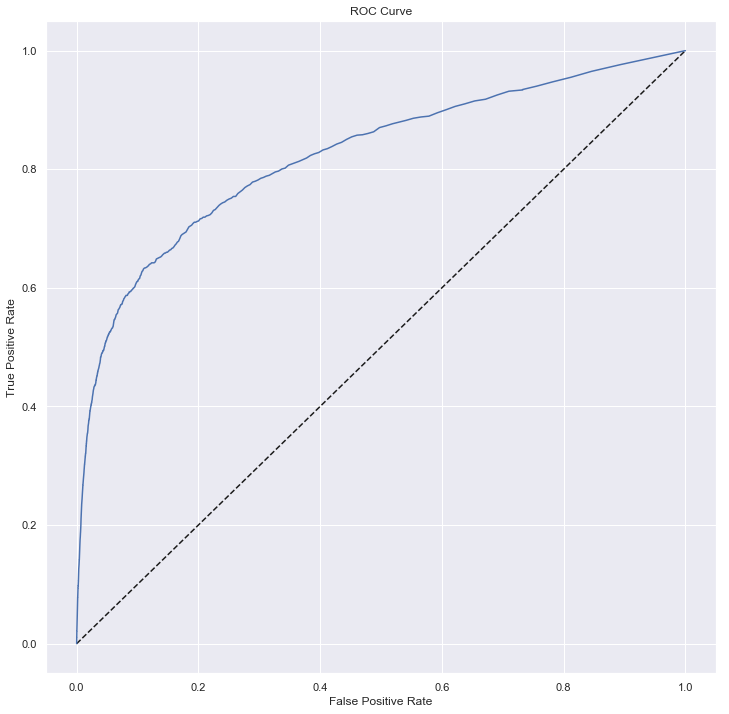

In [747]:
# ROC Curve
y_r_pred_prob = clf.predict_proba(X_test_2)[:,1]

auc_score = roc_auc_score(y_test_2, y_r_pred_prob)
print('ROC AUC Score: ' + str(auc_score))
print()

fpr, tpr, thresholds = roc_curve(y_test_2, y_r_pred_prob) # False Positive, True Positive, Threshold

plt.figure(figsize=(12,12))
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()


### Analysis of Predicted Probabilities from Random Forest (balanced w/ max 5 features)

The below graph shows the % of Actual Stops by the Predicted Probability of the Stop.  The Actual Stop % is good at the high predicted probabilities but there are fewer customers at the higher predicted probabilities.
<br><br>
You can see that if the company wanted to keep the accuracy of calling people who will actually stop over 30%, the company can choose to only call those people with more than a 80% chance of stopping.  The overall stats for the 80%+ chance of stopping predictions is a total of 248 predicted stops and 89 actual stops.  The overall actuals stop % would be around 36%.
<br><br>
This is the breakdown of Predicted Stop Count, Actual Stop Count, and Predicted Stop % by Predicted Probability:

| Predicted Probability | Predicted Stop Count | Actual Stop Count | Predicted Stop % |
|-----------------------|----------------------|-------------------|------------------|
| 0%                    | 0                    | 302               | 0%               |
| 10%                   | 0                    | 258               | 0%               |
| 20%                   | 0                    | 155               | 0%               |
| 30%                   | 0                    | 126               | 0%               |
| 40%                   | 0                    | 130               | 0%               |
| 50%                   | 409                  | 117               | 28.6%            |
| 60%                   | 664                  | 131               | 19.7%            |
| 70%                   | 455                  | 95                | 20.9%            |
| 80%                   | 175                  | 61                | 34.9%            |
| 90%                   | 59                   | 22                | 37.3%            |
| 100%                  | 14                   | 6                 | 42.9%            |



In [748]:
# Set up df_rt DataFrame to hold probability, prediction, and actual.
df_rf = X_test_2.copy()
df_rf['prob'] = y_r_pred_prob # Predicted probability
df_rf['prob'] = round(df_rf['prob'], 1) # Round to 1 decimal for visual.
df_rf['pred'] = y_pred # Predicted stop or not
df_rf['stop'] = y_test_2 # Actual stop value  

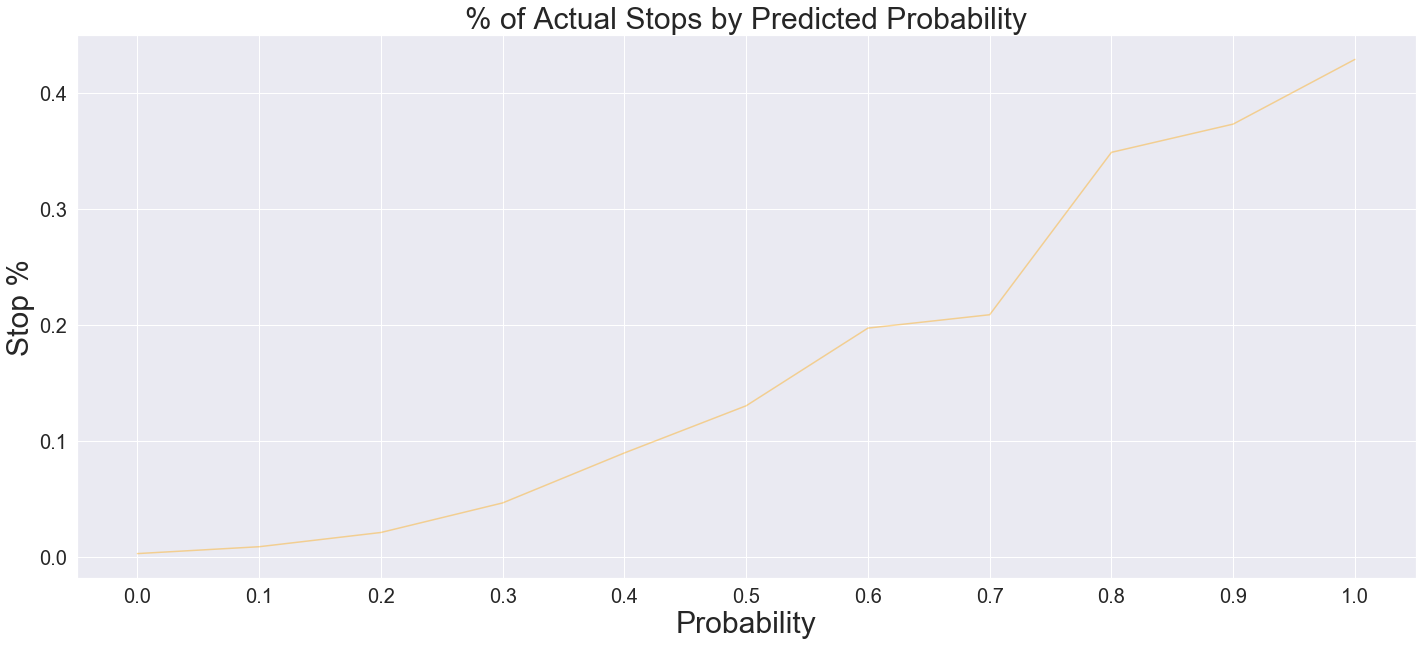

In [749]:


# Actual Stops by Predicted Probability #
plt.figure(figsize=(24,10))
#aaa[aaa['pred'] == 1].groupby('prob')['pred'].count().plot(kind='line', color='orange', alpha=.4, grid=True, label='7 Days')
df_rf.groupby('prob')['stop'].mean().plot(kind='line', color='orange', alpha=.4, grid=True)

plt.xlabel('Probability', fontsize=30)
plt.ylabel('Stop %', fontsize=30)
plt.title('% of Actual Stops by Predicted Probability', fontsize=30)
plt.xticks(np.arange(0,1.1,.1), fontsize=20)
plt.yticks( fontsize=20) 
plt.show()


## Splitting Up Data Based on Customer Class

### Train/Test/Split & Resampling with 20k stops and 40k starts

I ran the resampling with different values for stops and starts by customer class and these are the best performing ones I could find are:
* Residential - 20k Stops, 40k Active
* Landlords / Building/Developers - 500 Stops, 1k Active
* All Others - 1k Stops, 5k Active
<br>

The Customer Class was chosen to split up the data since Residential customers account for over 90% of customers but have < 1% stopped in the 21 day timeframe.  Landlord and Builders/Developers had 14% and 9% stop in the 21 day timeframe.

In [750]:
X2 = df2[['USAGE_PAST_18_BUCKET','CITY_NUM','CUSTOMER_CLASS_CODE_NUM','DNP_STARTED_FLAG_NUMBER','DNP_STOPPED_FLAG_NUMBER','INTERNAL_CREDIT_RATING','PERSON_RCVD_18_MTHS_PLEDGE_NUM','PAYMENTS_IN_LAST_18_MONTHS','BILLS_IN_LAST_18_MONTHS','ARREARS_PAYOFF_AMOUNT','TOTAL_PAYOFF_AMOUNT','LATE_PAYMENT_COUNT','SEASONAL_PRIOR_1_YR_FLAG_NUM','SEASONAL_PRIOR_2_YR_FLAG_NUM','SEASONAL_PRIOR_3_YR_FLAG_NUM','SA_START_AVG_TEMP','START_2013','START_2014','START_2015','START_2016','START_2017','START_2018','START_2019','PLEDGE_DATE_2017_NUM','PLEDGE_DATE_2018_NUM','PREMISE_DAYS_INACTIVE_BEFORE','PERSON_DAYS_INACTIVE_BEFORE','PREMISE_DAYS_ACTIVE_BEFORE','PERSON_DAYS_ACTIVE_BEFORE','ACTIVE_DIFF_FROM_20190301']]
X2['STOP_21_DAYS_FROM_20190301'] = df2['STOP_21_DAYS_FROM_20190301']

# Used for train_test_split.
res = X2[X2['CUSTOMER_CLASS_CODE_NUM'] == 1]   # RES
ll_bldv = X2[((X2['CUSTOMER_CLASS_CODE_NUM'] == 4) | (X2['CUSTOMER_CLASS_CODE_NUM'] == 5))]   # Landlord / Builder/Developer
other = X2[((X2['CUSTOMER_CLASS_CODE_NUM'] != 1) & (X2['CUSTOMER_CLASS_CODE_NUM'] != 4) & (X2['CUSTOMER_CLASS_CODE_NUM'] != 5))]   # ALL OTHERS

# Residential
X_res = res.drop(columns = ['STOP_21_DAYS_FROM_20190301'])
y_res = res['STOP_21_DAYS_FROM_20190301']

# Landlords & Building/Developers
X_llbldv = ll_bldv.drop(columns = ['STOP_21_DAYS_FROM_20190301'])
y_llbldv = ll_bldv['STOP_21_DAYS_FROM_20190301']

# All Others
X_other = other.drop(columns = ['STOP_21_DAYS_FROM_20190301'])
y_other = other['STOP_21_DAYS_FROM_20190301']

X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(X_res, y_res, test_size=.4, random_state=50)
X_train_llbldv, X_test_llbldv, y_train_llbldv, y_test_llbldv = train_test_split(X_llbldv, y_llbldv, test_size=.4, random_state=50)
X_train_other, X_test_other, y_train_other, y_test_other = train_test_split(X_other, y_other, test_size=.4, random_state=50)

print()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [751]:

# RESIDENTIAL #

X_train_res['STOP_21_DAYS_FROM_20190301'] = y_train_res

# Separating Stops and Active SAs who didn't stop
df_res_stop_21 = X_train_res[X_train_res['STOP_21_DAYS_FROM_20190301'] == 1] 
df_res_no_stop_21 = X_train_res[X_train_res['STOP_21_DAYS_FROM_20190301'] == 0]

# Downsample Active SAs to 10k #
stop_resample_count = 20000
resample_count = 40000

df_res_stop_21_samples = resample(df_res_stop_21, replace=True, n_samples=stop_resample_count, random_state=50) # Resampling
df_res_no_stop_21_samples = resample(df_res_no_stop_21, replace=True, n_samples=resample_count, random_state=50) # Resampling
print('Number of 21 Day Stops After: {}'.format(np.ma.count(df_res_stop_21_samples['STOP_21_DAYS_FROM_20190301'])))
print('Number of 21 Day non-Stops After: {}'.format(np.ma.count(df_res_no_stop_21_samples['STOP_21_DAYS_FROM_20190301'])))

df_resampled = pd.concat([df_res_stop_21_samples, df_res_no_stop_21_samples]) # combine all data
print('Count of Records after Resampling: {}'.format(np.ma.count(df_resampled['STOP_21_DAYS_FROM_20190301'])))

# Resampled dependent/independent.
# The # of stops was upsampled to be the same count as non-stops.
X_res_r = df_resampled.drop(columns = ['STOP_21_DAYS_FROM_20190301']) 
y_res_r = df_resampled['STOP_21_DAYS_FROM_20190301']

print()


# Landlords / Builders/Developers #

X_train_llbldv['STOP_21_DAYS_FROM_20190301'] = y_train_llbldv

# Separating Stops and Active SAs who didn't stop
df_llbldv_stop_21 = X_train_llbldv[X_train_llbldv['STOP_21_DAYS_FROM_20190301'] == 1] 
df_llbldv_no_stop_21 = X_train_llbldv[X_train_llbldv['STOP_21_DAYS_FROM_20190301'] == 0]

# Downsample Active SAs to 10k #
stop_resample_count = 500
resample_count = 1000

df_llbldv_stop_21_samples = resample(df_llbldv_stop_21, replace=True, n_samples=stop_resample_count, random_state=50) # Resampling
df_llbldv_no_stop_21_samples = resample(df_llbldv_no_stop_21, replace=True, n_samples=resample_count, random_state=50) # Resampling
print('Number of 21 Day Stops After: {}'.format(np.ma.count(df_llbldv_stop_21_samples['STOP_21_DAYS_FROM_20190301'])))
print('Number of 21 Day non-Stops After: {}'.format(np.ma.count(df_llbldv_no_stop_21_samples['STOP_21_DAYS_FROM_20190301'])))

df_resampled = pd.concat([df_llbldv_stop_21_samples, df_llbldv_no_stop_21_samples]) # combine all data
print('Count of Records after Resampling: {}'.format(np.ma.count(df_resampled['STOP_21_DAYS_FROM_20190301'])))

# Resampled dependent/independent.
# The # of stops was upsampled to be the same count as non-stops.
X_llbldv_r = df_resampled.drop(columns = ['STOP_21_DAYS_FROM_20190301']) 
y_llbldv_r = df_resampled['STOP_21_DAYS_FROM_20190301']

print()


# Others #

X_train_other['STOP_21_DAYS_FROM_20190301'] = y_train_other

# Separating Stops and Active SAs who didn't stop
df_other_stop_21 = X_train_other[X_train_other['STOP_21_DAYS_FROM_20190301'] == 1] 
df_other_no_stop_21 = X_train_other[X_train_other['STOP_21_DAYS_FROM_20190301'] == 0]

# Downsample Active SAs to 10k #
stop_resample_count = 1000
resample_count = 5000

df_other_stop_21_samples = resample(df_other_stop_21, replace=True, n_samples=stop_resample_count, random_state=50) # Resampling
df_other_no_stop_21_samples = resample(df_other_no_stop_21, replace=True, n_samples=resample_count, random_state=50) # Resampling
print('Number of 21 Day Stops After: {}'.format(np.ma.count(df_other_stop_21_samples['STOP_21_DAYS_FROM_20190301'])))
print('Number of 21 Day non-Stops After: {}'.format(np.ma.count(df_other_no_stop_21_samples['STOP_21_DAYS_FROM_20190301'])))

df_resampled = pd.concat([df_other_stop_21_samples, df_other_no_stop_21_samples]) # combine all data
print('Count of Records after Resampling: {}'.format(np.ma.count(df_resampled['STOP_21_DAYS_FROM_20190301'])))

# Resampled dependent/independent.
# The # of stops was upsampled to be the same count as non-stops.
X_other_r = df_resampled.drop(columns = ['STOP_21_DAYS_FROM_20190301']) 
y_other_r = df_resampled['STOP_21_DAYS_FROM_20190301']

print()




C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Number of 21 Day Stops After: 20000
Number of 21 Day non-Stops After: 40000
Count of Records after Resampling: 60000

Number of 21 Day Stops After: 500
Number of 21 Day non-Stops After: 1000
Count of Records after Resampling: 1500

Number of 21 Day Stops After: 1000
Number of 21 Day non-Stops After: 5000
Count of Records after Resampling: 6000



C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Residential
For Residential Customers, the top features are Number of Days Active, Total Payoff Amount, Arrears Payoff Amount, and Number of Payments and Bills.

The Confusion Matrix is showing:
* Accuracy: 98% (125,597 out of 127,514)
* Precision: 99% (tp / (tp + fp))
* Recall: 99% (tp / (tp + fn))
* F1 Score: 99% (2 * ((p * r) / (p + r)))
<br>

The confusion matrix is showing positive numbers and looking at the total savings from the custom scorer shows that the company would save over 17,000 dollars using this algorithm.
* Predicted 275 Stops out of 1,165 (24%)
* Out of the 1,302 predicted stops, only 275 were actual stops (21%)
<br><br>

<b>Total Savings: 17,230</b>

In [752]:
# Feature Importance

features = X_res_r.keys() # Store Feature Names

clf = RandomForestClassifier(n_estimators=1000,  random_state=50, n_jobs=-1) # 1000 Trees
clf.fit(X_res_r, y_res_r)

for feature in zip(features, clf.feature_importances_): # Print each feature with gini score.
    print(feature)

('USAGE_PAST_18_BUCKET', 0.061047603951961245)
('CITY_NUM', 0.05712333391571883)
('CUSTOMER_CLASS_CODE_NUM', 0.0)
('DNP_STARTED_FLAG_NUMBER', 0.0059538113481522326)
('DNP_STOPPED_FLAG_NUMBER', 0.03357201000227512)
('INTERNAL_CREDIT_RATING', 0.05109961096776118)
('PERSON_RCVD_18_MTHS_PLEDGE_NUM', 0.00236549533333865)
('PAYMENTS_IN_LAST_18_MONTHS', 0.09027482564262511)
('BILLS_IN_LAST_18_MONTHS', 0.065988042865589)
('ARREARS_PAYOFF_AMOUNT', 0.09386130157839902)
('TOTAL_PAYOFF_AMOUNT', 0.09705586330478123)
('LATE_PAYMENT_COUNT', 0.022064917456968924)
('SEASONAL_PRIOR_1_YR_FLAG_NUM', 0.002847384943651626)
('SEASONAL_PRIOR_2_YR_FLAG_NUM', 0.003355806292280804)
('SEASONAL_PRIOR_3_YR_FLAG_NUM', 0.003916517928592161)
('SA_START_AVG_TEMP', 0.06890728854595443)
('START_2013', 0.0022913320560463252)
('START_2014', 0.0023792697018952436)
('START_2015', 0.002443831995013168)
('START_2016', 0.002949216268960746)
('START_2017', 0.0033881689921308905)
('START_2018', 0.012629033035900792)
('START_2019'

In [753]:
# FEATURES = 5

clf = RandomForestClassifier(n_estimators=100,  random_state=50, max_features=5, n_jobs=-1) # max_depth=100,
clf.fit(X_res_r, y_res_r)

y_pred = clf.predict(X_test_res)

print_stats(y_test_res, y_pred)

Confusion Matrix:
[[125322   1027]
 [   890    275]]


Total Savings 17230


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    126349
           1       0.21      0.24      0.22      1165

   micro avg       0.98      0.98      0.98    127514
   macro avg       0.60      0.61      0.61    127514
weighted avg       0.99      0.98      0.99    127514


Accuracy Score: 0.9849663566353498


### Landlords & Builders/Developers
For Landlords and Builders/Develops, the top features are Number of Days Active, Person/Premise Days Active Before, Person Days Inactive Before, Total Payoff Amount, Arrears Payoff Amount, and Number of Payments and Bills.

The Confusion Matrix is showing:
* Accuracy: 81% (730 out of 899)
* Precision: 87% (tp / (tp + fp))
* Recall: 92% (tp / (tp + fn))
* F1 Score: 89% (2 * ((p * r) / (p + r)))
<br>

The confusion matrix is showing positive numbers and looking at the total savings from the custom scorer shows that the company would save over 1,000 dollars using this algorithm.
* Predicted 19 Stops out of 122 (16%)
* Out of the 85 predicted stops, only 19 were actual stops (22%)
<br><br>

<b>Total Savings: 1,240</b>

In [754]:
# Feature Importance

features = X_llbldv_r.keys() # Store Feature Names

clf = RandomForestClassifier(n_estimators=8,  random_state=50, n_jobs=-1) # 1000 Trees
clf.fit(X_llbldv_r, y_llbldv_r)

for feature in zip(features, clf.feature_importances_): # Print each feature with gini score.
    print(feature)

('USAGE_PAST_18_BUCKET', 0.052328210861808125)
('CITY_NUM', 0.05589983006345151)
('CUSTOMER_CLASS_CODE_NUM', 0.014509825386633422)
('DNP_STARTED_FLAG_NUMBER', 0.006764975627891454)
('DNP_STOPPED_FLAG_NUMBER', 0.0017091305821926946)
('INTERNAL_CREDIT_RATING', 0.03221396488129624)
('PERSON_RCVD_18_MTHS_PLEDGE_NUM', 0.004749853036687225)
('PAYMENTS_IN_LAST_18_MONTHS', 0.0802287254740117)
('BILLS_IN_LAST_18_MONTHS', 0.0727405482688751)
('ARREARS_PAYOFF_AMOUNT', 0.06209836180251994)
('TOTAL_PAYOFF_AMOUNT', 0.066299812289449)
('LATE_PAYMENT_COUNT', 0.017224405523541007)
('SEASONAL_PRIOR_1_YR_FLAG_NUM', 0.006699885452890893)
('SEASONAL_PRIOR_2_YR_FLAG_NUM', 0.014032479969640422)
('SEASONAL_PRIOR_3_YR_FLAG_NUM', 0.00394228261449465)
('SA_START_AVG_TEMP', 0.07076472225426922)
('START_2013', 0.00010417700109747018)
('START_2014', 0.003794538627533731)
('START_2015', 0.0)
('START_2016', 0.0002777374583056375)
('START_2017', 0.0052131620707658284)
('START_2018', 0.0053483511649754885)
('START_2019

In [755]:
# FEATURES = 5

# Using the actual data

clf = RandomForestClassifier(n_estimators=8,  random_state=50, max_features=5, n_jobs=-1) # max_depth=100,
clf.fit(X_llbldv_r, y_llbldv_r)

y_pred = clf.predict(X_test_llbldv)

print_stats(y_test_llbldv, y_pred)

Confusion Matrix:
[[711  66]
 [103  19]]


Total Savings 1240


Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.92      0.89       777
           1       0.22      0.16      0.18       122

   micro avg       0.81      0.81      0.81       899
   macro avg       0.55      0.54      0.54       899
weighted avg       0.79      0.81      0.80       899


Accuracy Score: 0.8120133481646273


### All Other Customer Classes
For all other customer classes, the top features are Number of Days Active, Person/Premise Days Active Before, Person Days Inactive Before, SA Start Average Temp, Total Payoff Amount, Arrears Payoff Amount, Number of Payments and Bills, and DNP Stopped Flag.

The Confusion Matrix is showing:
* Accuracy: 99% (7,973 out of 8,068)
* Precision: 99% (tp / (tp + fp))
* Recall: 99% (tp / (tp + fn))
* F1 Score: 99% (2 * ((p * r) / (p + r)))
<br>

The confusion matrix is showing positive numbers and looking at the total savings from the custom scorer shows that the company would save over 100 dollars using this algorithm.
* Predicted 4 Stops out of 74 (5%)
* Out of the 29 predicted stops, only 4 were actual stops (14%)
<br><br>

<b>Total Savings: 150</b>

In [756]:
# Feature Importance

features = X_other_r.keys() # Store Feature Names

clf = RandomForestClassifier(n_estimators=20,  random_state=50, n_jobs=-1) # 1000 Trees
clf.fit(X_other_r, y_other_r)

for feature in zip(features, clf.feature_importances_): # Print each feature with gini score.
    print(feature)

('USAGE_PAST_18_BUCKET', 0.06276139225628728)
('CITY_NUM', 0.061202077822369416)
('CUSTOMER_CLASS_CODE_NUM', 0.0035093471475805887)
('DNP_STARTED_FLAG_NUMBER', 0.007933032540915132)
('DNP_STOPPED_FLAG_NUMBER', 0.05768639642008294)
('INTERNAL_CREDIT_RATING', 0.043398916795169495)
('PERSON_RCVD_18_MTHS_PLEDGE_NUM', 0.0033870695511038266)
('PAYMENTS_IN_LAST_18_MONTHS', 0.0748209513888549)
('BILLS_IN_LAST_18_MONTHS', 0.04354226596452263)
('ARREARS_PAYOFF_AMOUNT', 0.07953173213739397)
('TOTAL_PAYOFF_AMOUNT', 0.0862991286369788)
('LATE_PAYMENT_COUNT', 0.05176742991622366)
('SEASONAL_PRIOR_1_YR_FLAG_NUM', 0.006070746871607026)
('SEASONAL_PRIOR_2_YR_FLAG_NUM', 0.002331969868675301)
('SEASONAL_PRIOR_3_YR_FLAG_NUM', 0.0032032962306792053)
('SA_START_AVG_TEMP', 0.0621259822265659)
('START_2013', 0.0031633719726521193)
('START_2014', 0.0037488750054508147)
('START_2015', 0.006488465887325901)
('START_2016', 0.007270578194130996)
('START_2017', 0.003469265771728726)
('START_2018', 0.007829779658553

In [757]:
# FEATURES = 5

# Using the actual data

clf = RandomForestClassifier(n_estimators=20,  random_state=50, max_features=5, n_jobs=-1) # max_depth=100,
clf.fit(X_other_r, y_other_r)

y_pred = clf.predict(X_test_other)

print_stats(y_test_other, y_pred)

Confusion Matrix:
[[7969   25]
 [  70    4]]


Total Savings 150


Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      7994
           1       0.14      0.05      0.08        74

   micro avg       0.99      0.99      0.99      8068
   macro avg       0.56      0.53      0.54      8068
weighted avg       0.98      0.99      0.99      8068


Accuracy Score: 0.9882250867625186


## ANNEX

## Logistic Regression
Using actual dataset.

In [336]:
n_CV = 10

logreg = LogisticRegression(solver='liblinear') # Create the classifier

print_cv_scores(logreg, X_test, y_test, savings_scorer, n_CV, -1) # Print cross_val_score using custom scoring 

logreg.fit(X_train, y_train) # Fit the classifier to the training data

y_pred = logreg.predict(X_test) # Predict the labels of the test set

print_stats(y_test, y_pred)


CV Scores:
[-1410 -1410 -1410 -1290 -1400 -1400 -1400 -1400 -1400 -1400]

Accuracy: -1392.00 (+/- 68.59)

Total Savings: -13920.0



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Confusion Matrix:
[[135077      0]
 [  1403      0]]


Total Savings 0


Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    135077
           1       0.00      0.00      0.00      1403

   micro avg       0.99      0.99      0.99    136480
   macro avg       0.49      0.50      0.50    136480
weighted avg       0.98      0.99      0.98    136480


Accuracy Score: 0.9897201055099648


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Using the upsampling of 200k stops and 200k active
The Confusion Matrix is showing:
* Accuracy: 80% (109,130 out of 136,480)
* Precision: 99% (tp / (tp + fp))
* Recall: 80% (tp / (tp + fn))
* F1 Score: 89% (2 * ((p * r) / (p + r)))
<br>

So the confusion matrix is showing okay numbers but looking at the total savings from the custom scorer shows that the company would lose over 171,000 dollars using this algorithm.
* Predicted 981 Stops out of 1,403 (70%)
* Out of the 27,909 predicted stops, only 981 were actual stops (4%)
<br><br>

<b>Total Savings: -171,180</b>

In [345]:
# GridSearchCV with LogReg
n_CV = 5

logreg = LogisticRegression(solver='liblinear') # Create the classifier

penalty = ['l1', 'l2'] # regularization penablty space
C = np.logspace(0, 4, 3) # regularization hyperparameter space

param_grid = dict(C=C, penalty=penalty)

logreg_cv = GridSearchCV(logreg, param_grid, cv=n_CV, scoring=savings_scorer, n_jobs=-1) # 5 fold

logreg_cv.fit(X_r, y_r) # Fit the classifier to the training data

y_pred = logreg_cv.predict(X_test_2) # Predict the labels of the test set

print_stats(y_test_2, y_pred)


Confusion Matrix:
[[108155  26922]
 [   422    981]]


Total Savings -171120


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.80      0.89    135077
           1       0.04      0.70      0.07      1403

   micro avg       0.80      0.80      0.80    136480
   macro avg       0.52      0.75      0.48    136480
weighted avg       0.99      0.80      0.88    136480


Accuracy Score: 0.7996483001172333


### Using the upsampling of 2k stops and downsampling of 10k active
The Confusion Matrix is showing:
* Accuracy: 95% (129,842 out of 136,480)
* Precision: 99% (tp / (tp + fp))
* Recall: 96% (tp / (tp + fn))
* F1 Score: 97% (2 * ((p * r) / (p + r)))
<br>

The confusion matrix is showing better numbers but looking at the total savings from the custom scorer shows that the company would still lose over 8,000 dollars using this algorithm.
* Predicted 485 Stops out of 1,403 (35%)
* Out of the 6,205 predicted stops, only 485 were actual stops (8%)
<br><br>

<b>Total Savings: -8,700</b>

In [346]:
# GridSearchCV with LogReg
n_CV = 5

logreg = LogisticRegression(solver='liblinear') # Create the classifier

penalty = ['l1', 'l2'] # regularization penablty space
C = np.logspace(0, 4, 3) # regularization hyperparameter space
param_grid = dict(C=C, penalty=penalty)

logreg_cv = GridSearchCV(logreg, param_grid, cv=n_CV, scoring=savings_scorer, n_jobs=-1) # 5 fold

logreg_cv.fit(X_r2, y_r2) # Fit the classifier to the training data

y_pred = logreg_cv.predict(X_test_2) # Predict the labels of the test set

print_stats(y_test_2, y_pred)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Confusion Matrix:
[[129357   5720]
 [   918    485]]


Total Savings -8700


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97    135077
           1       0.08      0.35      0.13      1403

   micro avg       0.95      0.95      0.95    136480
   macro avg       0.54      0.65      0.55    136480
weighted avg       0.98      0.95      0.97    136480


Accuracy Score: 0.951362837045721


### 2k Stops, 10k Active

In [ ]:
n_CV = 10

logreg = LogisticRegression(solver='liblinear') # Create the classifier

print_cv_scores(logreg, X_test_2, y_test_2, savings_scorer, n_CV, -1) # Print cross_val_score using custom scoring 

logreg.fit(X_r2, y_r2) # Fit the classifier to the training data

y_pred = logreg.predict(X_test_2) # Predict the labels of the test set

print_stats(y_test_2, y_pred)


## Logistic Regression (balanced)

### Using the upsampling of 200k stops and 200k active
The Confusion Matrix is showing:
* Accuracy: 80% (109,120 out of 136,480)
* Precision: 99% (tp / (tp + fp))
* Recall: 80% (tp / (tp + fn))
* F1 Score: 89% (2 * ((p * r) / (p + r)))
<br>

The confusion matrix is showing okay numbers but looking at the total savings from the custom scorer shows that the company would lose over 171,000 dollars using this algorithm.
* Predicted 981 Stops out of 1,403 (70%)
* Out of the 27,919 predicted stops, only 981 were actual stops (4%)
<br><br>

<b>Total Savings: -171,280</b>

In [348]:
# Cross Validation w/ Balance
n_CV = 5

penalty = ['l1', 'l2'] # regularization penablty space
C = np.logspace(0, 4, 3) # regularization hyperparameter space
param_grid = dict(C=C, penalty=penalty)

logreg = LogisticRegression(solver='liblinear', class_weight='balanced') # Create the classifier

logreg_cv = GridSearchCV(logreg, param_grid, cv=n_CV, scoring=savings_scorer, n_jobs=-1) # 5 fold

logreg_cv.fit(X_r, y_r) # Fit the classifier to the training data

y_pred = logreg_cv.predict(X_test_2) # Predict the labels of the test set

print_stats(y_test_2, y_pred)


Confusion Matrix:
[[108182  26895]
 [   422    981]]


Total Savings -170850


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.80      0.89    135077
           1       0.04      0.70      0.07      1403

   micro avg       0.80      0.80      0.80    136480
   macro avg       0.52      0.75      0.48    136480
weighted avg       0.99      0.80      0.88    136480


Accuracy Score: 0.7998461313012896


### Using the upsampling of 2k stops and 10k active
The Confusion Matrix is showing:
* Accuracy: 80% (108,940 out of 136,480)
* Precision: 99% (tp / (tp + fp))
* Recall: 80% (tp / (tp + fn))
* F1 Score: 89% (2 * ((p * r) / (p + r)))
<br>

The confusion matrix is showing okay numbers but looking at the total savings from the custom scorer shows that the company would lose over 172,000 dollars using this algorithm.
* Predicted 986 Stops out of 1,403 (70%)
* Out of the 28,109 predicted stops, only 981 were actual stops (3%)
<br><br>

<b>Total Savings: -172,630</b>

In [349]:
# Cross Validation w/ Balance
n_CV = 10

penalty = ['l1', 'l2'] # regularization penablty space
C = np.logspace(0, 4, 3) # regularization hyperparameter space
param_grid = dict(C=C, penalty=penalty)

logreg = LogisticRegression(solver='liblinear', class_weight='balanced') # Create the classifier

logreg_cv = GridSearchCV(logreg, param_grid, cv=n_CV, scoring=savings_scorer, n_jobs=-1) # 5 fold

logreg_cv.fit(X_r2, y_r2) # Fit the classifier to the training data

y_pred = logreg_cv.predict(X_test_2) # Predict the labels of the test set

print_stats(y_test_2, y_pred)


Confusion Matrix:
[[107950  27127]
 [   417    986]]


Total Savings -172670


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.80      0.89    135077
           1       0.04      0.70      0.07      1403

   micro avg       0.80      0.80      0.80    136480
   macro avg       0.52      0.75      0.48    136480
weighted avg       0.99      0.80      0.88    136480


Accuracy Score: 0.7981828839390387


### 20k Stops, 40k Active

In [ ]:
n_CV = 10

logreg = LogisticRegression(solver='liblinear') # Create the classifier

print_cv_scores(logreg, X_test_2, y_test_2, savings_scorer, n_CV, -1) # Print cross_val_score using custom scoring 

logreg.fit(X_r3, y_r3) # Fit the classifier to the training data

y_pred = logreg.predict(X_test_2) # Predict the labels of the test set

print_stats(y_test_2, y_pred)


## Logistic Regression (balanced)
Using actual dataset.

In [337]:
# Logistic Regression (balanced)

logreg_bal = LogisticRegression(solver='liblinear', penalty='l2', class_weight='balanced', C=1) # Create the classifier

print_cv_scores(logreg_bal, X_test, y_test, savings_scorer, n_CV, -1) # Print cross_val_score using custom scoring 

logreg_bal.fit(X_train, y_train) # Fit the classifier to the training data

y_pred = logreg_bal.predict(X_test) # Predict the labels of the test set

print_stats(y_test, y_pred)


CV Scores:
[ 7940 11020  9810  9270  9380  9050  9600 10590 10260  9490]

Accuracy: 9641.00 (+/- 1635.47)

Total Savings: 96410.0



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Confusion Matrix:
[[104022  31055]
 [   434    969]]


Total Savings -213650


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.77      0.87    135077
           1       0.03      0.69      0.06      1403

   micro avg       0.77      0.77      0.77    136480
   macro avg       0.51      0.73      0.46    136480
weighted avg       0.99      0.77      0.86    136480


Accuracy Score: 0.7692775498241501


## SVM

In [338]:
# svm_test(X_train, y_train, X_test, y_test, 5000, [.5, 1.0, 1.5, 2.0, 4.0, 8.0, 10.0])

In [339]:
linSVC = svm.LinearSVC(random_state=50,  max_iter = 1000, C=4.0) # tol=1e-5,
linSVC.fit(X_r3, y_r3)

y_r_pred = linSVC.predict(X_test_2)

print_stats(y_test_2, y_r_pred)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Confusion Matrix:
[[114119  20958]
 [   678    725]]


Total Savings -137080


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.84      0.91    135077
           1       0.03      0.52      0.06      1403

   micro avg       0.84      0.84      0.84    136480
   macro avg       0.51      0.68      0.49    136480
weighted avg       0.98      0.84      0.90    136480


Accuracy Score: 0.8414712778429074


In [340]:
# TESTING
temp = clf.predict_proba(X_test)

In [ ]:
print(logreg_cv.best_estimator_)
print()
print(logreg_cv.best_params_)

print_cv_scores(logreg, X_r2, y_r2, savings_scorer, n_CV, -1) # Print cross_val_score using custom scoring on training data.


In [ ]:
# Cross Validation w/ Balance
n_CV = 10

penalty = ['l1', 'l2'] # regularization penablty space
C = np.logspace(0, 4, 3) # regularization hyperparameter space
param_grid = dict(C=C, penalty=penalty)

logreg = LogisticRegression(solver='liblinear', class_weight='balanced') # Create the classifier

logreg_cv = GridSearchCV(logreg, param_grid, cv=n_CV, scoring=savings_scorer, n_jobs=-1) # 5 fold

logreg_cv.fit(X_r3, y_r3) # Fit the classifier to the training data

#print(logreg_cv.best_estimator_)
#print()
#print(logreg_cv.best_params_)

print_cv_scores(logreg, X_r3, y_r3, savings_scorer, n_CV, -1) # Print cross_val_score using custom scoring on training data.

y_pred = logreg_cv.predict(X_test_2) # Predict the labels of the test set

print_stats(y_test_2, y_pred)


In [ ]:
# Residential
# class_weight = 'balanced'

# Using the actual data

clf = RandomForestClassifier(n_estimators=100,  random_state=50, max_features=5, class_weight = 'balanced', n_jobs=-1) # max_depth=100,
clf.fit(X_res_r, y_res_r)

y_pred = clf.predict(X_test_res)

print_stats(y_test_res, y_pred)


In [ ]:
# LL / BLDV
# class_weight = 'balanced'

# Using the actual data

clf = RandomForestClassifier(n_estimators=5,  random_state=50, max_features=5, class_weight = 'balanced', n_jobs=-1) # max_depth=100,
clf.fit(X_llbldv_r, y_llbldv_r)

y_pred = clf.predict(X_test_llbldv)

print_stats(y_test_llbldv, y_pred)


In [ ]:
# Other Customer Class
# class_weight = 'balanced'

# Using the actual data

clf = RandomForestClassifier(n_estimators=20,  random_state=50, max_features=5, class_weight = 'balanced', n_jobs=-1) # max_depth=100,
clf.fit(X_other_r, y_other_r)

y_pred = clf.predict(X_test_other)

print_stats(y_test_other, y_pred)


In [ ]:
plt.figure(figsize=(24,10))
#aaa[aaa['pred'] == 1].groupby('prob')['pred'].count().plot(kind='line', color='orange', alpha=.4, grid=True, label='7 Days')
df_rf.groupby('prob')['pred'].mean().plot(kind='line', color='orange', alpha=.4, grid=True, label='7 Days')

plt.show()


In [ ]:
df_rf[df_rf['stop'] == 1].groupby('prob')['stop'].count()
df_rf[df_rf['pred'] == 1].groupby('prob')['stop'].count()